## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import warnings

from raccoon import WiggleCleaner

## Load data

The example data used in this demo is a clipped version of the data from [Perna et al. (2023)](https://www.aanda.org/articles/aa/full_html/2023/11/aa46649-23/aa46649-23.html).

In [ ]:
datacube_file = "./example_data.fits"
data_cube, header = fits.getdata(datacube_file, header=True)
# Attention: default pipeline-reduced datacubes will have the noise layer at ext=2
noise_cube = fits.getdata(datacube_file, ext=1)

wavelengths = (header["CRVAL3"] + header["CDELT3"] * np.arange(header["NAXIS3"])) * 1e4

data_cube.shape, noise_cube.shape, wavelengths.shape

((1363, 33, 33), (1363, 33, 33), (1363,))

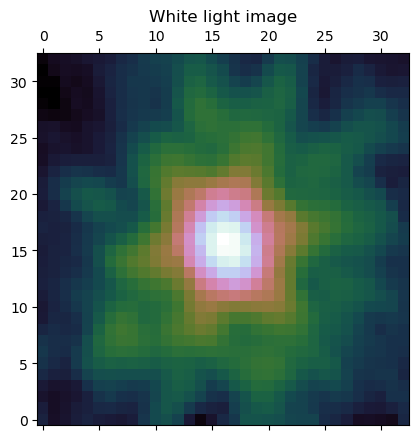

In [3]:
plt.matshow(np.log10(np.nansum(data_cube, axis=0)), cmap="cubehelix", origin="lower")
plt.title("White light image")
plt.show()

In [4]:
quasar_x, quasar_y = 16, 16

### Identify lines to make gaps in the fitting

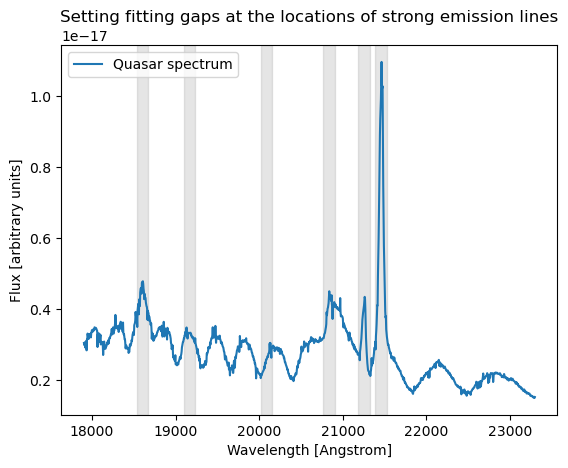

In [5]:
gaps = [
    [18541.43, 18665.54],
    [19099.23, 19227.08],
    [20016.21, 20150.19],
    [20766.39, 20905.39],
    [21183.25, 21325.04],
    [21388.00, 21531.16],
]

plt.plot(wavelengths, data_cube[:, quasar_y, quasar_x], label="Quasar spectrum")

for gap in gaps:
    plt.axvspan(gap[0], gap[1], color="grey", alpha=0.2)

plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux [arbitrary units]")
plt.legend()
plt.title("Setting fitting gaps at the locations of strong emission lines")
plt.show()

### Create the `WiggleCleaner` object

In [6]:
wcleaner = WiggleCleaner(
    wavelengths,
    data_cube,
    noise_cube,
    gaps=gaps,
    symmetric_sharpenning=True,
    asymmetric_sharpenning=True,
)

## Check for optimal aperture size 

To determine the baseline spectra for each aperture

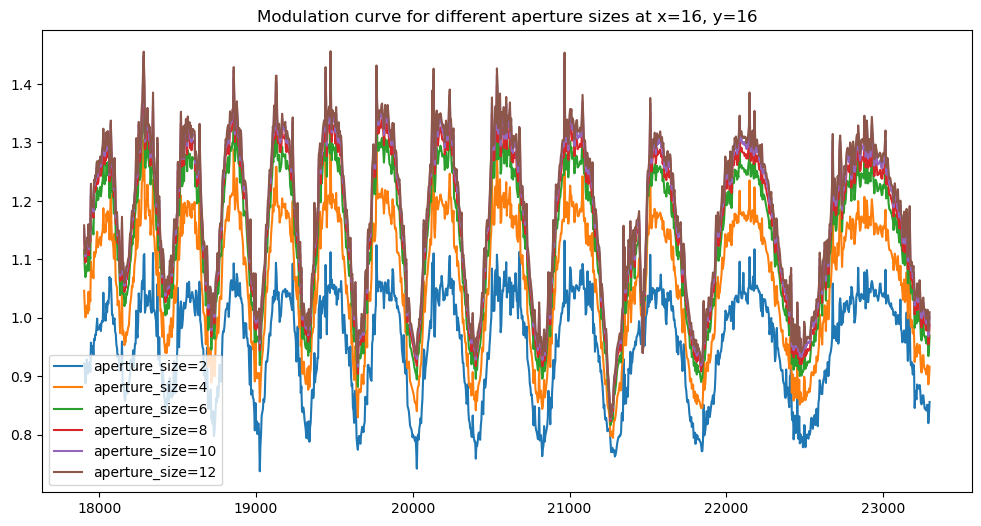

In [12]:
plt.rcParams["figure.figsize"] = (12, 6)

for s in np.arange(2, 13, 2):
    modulation_curve, modulation_curve_noise = wcleaner.get_modulation_curve(
        quasar_x, quasar_y, s
    )
    plt.plot(wavelengths, modulation_curve, label=f"aperture_size={s}")

plt.legend()
plt.title(
    f"Modulation curve for different aperture sizes at x={quasar_x}, y={quasar_y}"
)
plt.show()

Choosing `aperture_size = 8` for the remainder of this demo, but you may want to experiment and tune for the best suitability for your data and use case.

In [ ]:
aperture_size = 8
modulation_curve, modulation_curve_noise = wcleaner.get_modulation_curve(
    quasar_x, quasar_y, aperture_size=aperture_size
)

## First look into how fitting of the wiggles looks like

Loss:  26224.8160166339


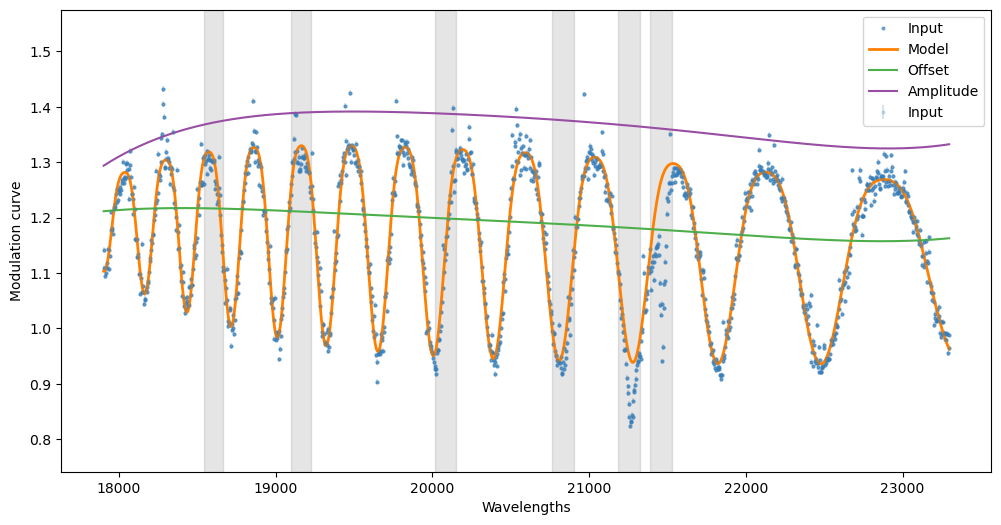

In [14]:
result_params = wcleaner.fit_curve(
    modulation_curve,
    noise=modulation_curve_noise,  # np.ones_like(curve_noise) * 0.005,
    plot=True,
    n_amplitude=5,
    n_offset=5,
    n_frequency=3,
    proximity_threshold=30,  # minimum distance between peaks/troughs to help avoid initial misidentification
    plot_amplitude_offset=True,
    verbose=True,
    specified_noise_level=0.005,  # set custom noise level for each wavelength pixel in place of the original noise
)

Note the assymetric sharpness between peaks and troughs. To allow for this, we have to set the `asymmetric_sharpenning=True` in the `WiggleCleaner` initialization. The `symmetric_sharpening` is also set to `True` for sharper peaks than a sine function. These two options can be chosen individually, and you may experiment for the best settings suited for your use case.

The model for the modulation curve is:
$$
w(x) = 1 + A(x) \left[ \sin(\phi(x)) + k_1  \sin(\phi(x))^2 + k_2  \sin(3\phi(x))\right] + c(x)
$$

Here, $\sin(\phi(x))^2$ term creates the asymmetric sharpness, and the $\sin(3\phi(x))$ term creates the symmetric sharpness. The phase $\phi(x)$, amplitude $A(x)$ and continuum offset $c(x)$ are described with polynomials with orders `n_frequency`, `n_amplitude`, `n_offset`, respectively.

## Using BIC to select the best combination of polynomial orders

Computing BIC for choices of n_amplitude...


  0%|          | 0/10 [00:00<?, ?it/s]

n_amplitude: 10, n_offset: 5, n_frequency: 4, BIC: 14040.287329471868
n_amplitude: 10, n_offset: 5, n_frequency: 3, BIC: 14033.343981203801
n_amplitude: 10, n_offset: 5, n_frequency: 2, BIC: 14029.4371874391
n_amplitude: 10, n_offset: 4, n_frequency: 3, BIC: 14027.468116241063
n_amplitude: 10, n_offset: 4, n_frequency: 2, BIC: 14022.336922379993
n_amplitude: 10, n_offset: 3, n_frequency: 3, BIC: 14021.126651016575
n_amplitude: 10, n_offset: 3, n_frequency: 2, BIC: 14017.376877088373
n_amplitude: 9, n_offset: 3, n_frequency: 3, BIC: 14016.08838541516
n_amplitude: 9, n_offset: 3, n_frequency: 2, BIC: 14012.802032602269
n_amplitude: 8, n_offset: 4, n_frequency: 2, BIC: 14011.290779464176
n_amplitude: 8, n_offset: 3, n_frequency: 3, BIC: 14009.077072804459
n_amplitude: 8, n_offset: 3, n_frequency: 2, BIC: 14006.278289776274
n_amplitude: 8, n_offset: 2, n_frequency: 3, BIC: 14005.90299876997
n_amplitude: 8, n_offset: 2, n_frequency: 2, BIC: 14000.766847067614
n_amplitude: 7, n_offset: 3, n_

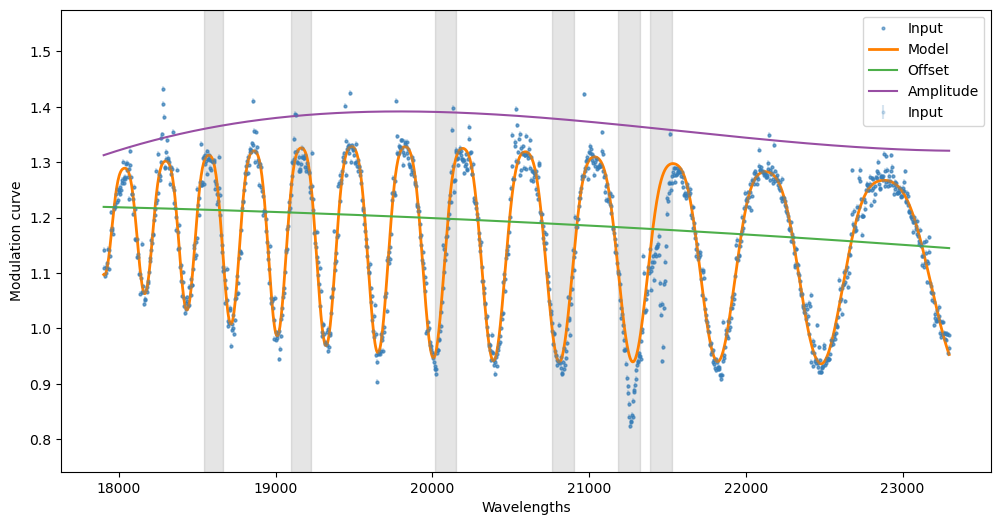

array([ 4.04816307e+01, -1.29590981e+01,  1.26075829e-01,  5.19167033e+01,
        1.62884885e-01,  2.63447672e-02, -2.83159356e-02,  1.49009543e-02,
        1.86772193e-01, -3.72096426e-02, -4.58455368e-03, -3.24190684e-01,
        9.47359783e-03])

In [15]:
wcleaner.fit_curve_with_best_bic(
    modulation_curve,
    noise=modulation_curve_noise,
    n_amplitude=10,
    n_offset=5,
    n_frequency=4,
    min_n_amplitude=1,
    min_n_offset=1,
    min_n_frequency=1,
    proximity_threshold=100,
    plot=True,
    plot_amplitude_offset=True,
    specified_noise_level=0.005,
)

## Finally, let `raccoon` clean your whole datacube. 🦝

You have the option to choose a set of fixed polynomial orders for all the spaxels by setting `None` for `min_n_amplitude`, `min_n_offset`, `min_n_frequency`. However, if non-`None` values are provided, the combination with the best BIC will be chosen within the specified range.

Cleaning spaxels:   0%|          | 0/25 [00:00<?, ?it/s]

Wiggle detected!! Cleaning spaxel: 14, 15...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16481.95744244917
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 16379.027618697184
n_amplitude: 5, n_offset: 3, n_frequency: 1, BIC: 16371.872441672362
n_amplitude: 5, n_offset: 2, n_frequency: 1, BIC: 16367.799428327777
n_amplitude: 5, n_offset: 1, n_frequency: 1, BIC: 16366.142463550845
n_amplitude: 4, n_offset: 3, n_frequency: 1, BIC: 16365.099460044725
n_amplitude: 4, n_offset: 2, n_frequency: 1, BIC: 16363.538932396576
n_amplitude: 4, n_offset: 1, n_frequency: 1, BIC: 16360.181398116765
n_amplitude: 3, n_offset: 3, n_frequency: 1, BIC: 16359.133078092476
n_amplitude: 3, n_offset: 2, n_frequency: 1, BIC: 16356.652198478805
n_amplitude: 3, n_offset: 1, n_frequency: 1, BIC: 16355.655773233204
n_amplitude: 2, n_offset: 3, n_frequency: 1, BIC: 16351.945837964866
n_amplitude: 2, n_offset: 2, n_frequency: 1, BIC: 16349.471362812272
n_amplitude: 2, n_offset: 1, n_frequency: 1, BIC: 16348.443503668168
Best n_amplitude:  2
Best n_offset:

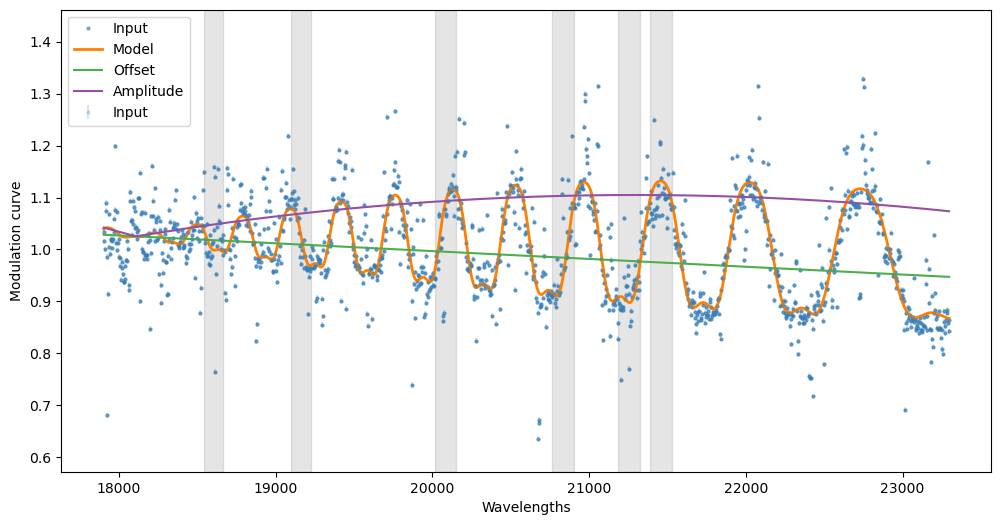

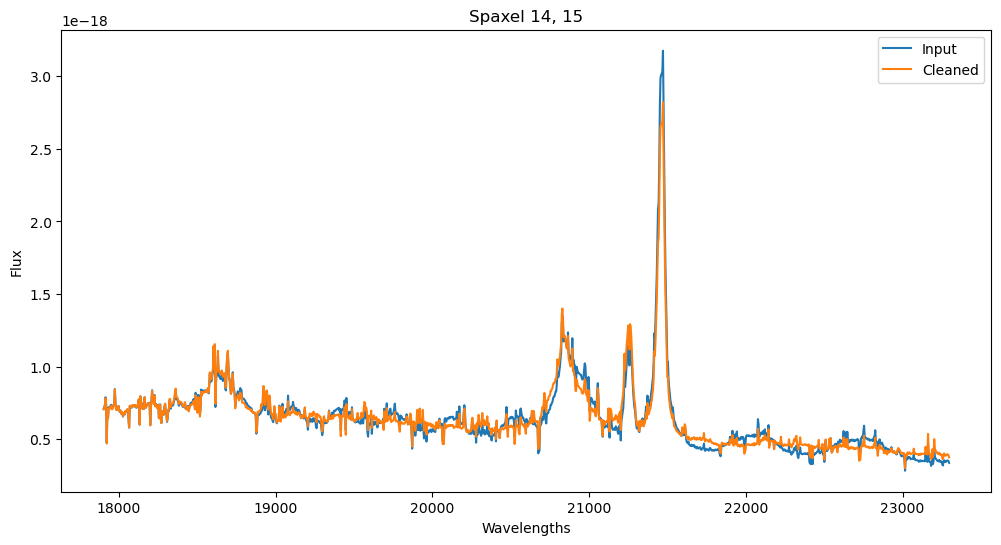

Wiggle detected!! Cleaning spaxel: 14, 16...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 17893.05981306014
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 16506.142816715812
n_amplitude: 5, n_offset: 3, n_frequency: 1, BIC: 16496.345567443444
n_amplitude: 5, n_offset: 1, n_frequency: 3, BIC: 16480.006747436004
n_amplitude: 4, n_offset: 1, n_frequency: 3, BIC: 16474.16184852951
Best n_amplitude:  4
Best n_offset:  1
Best n_frequency:  3


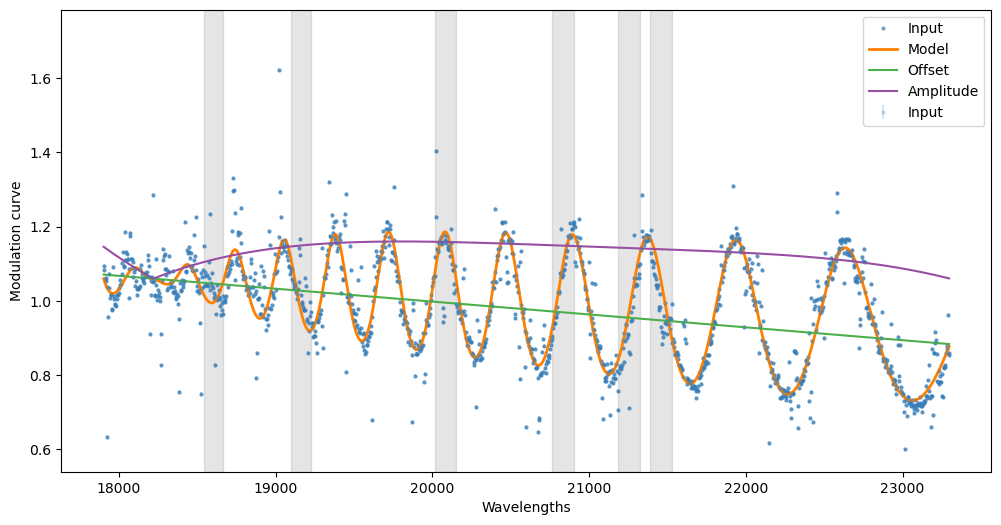

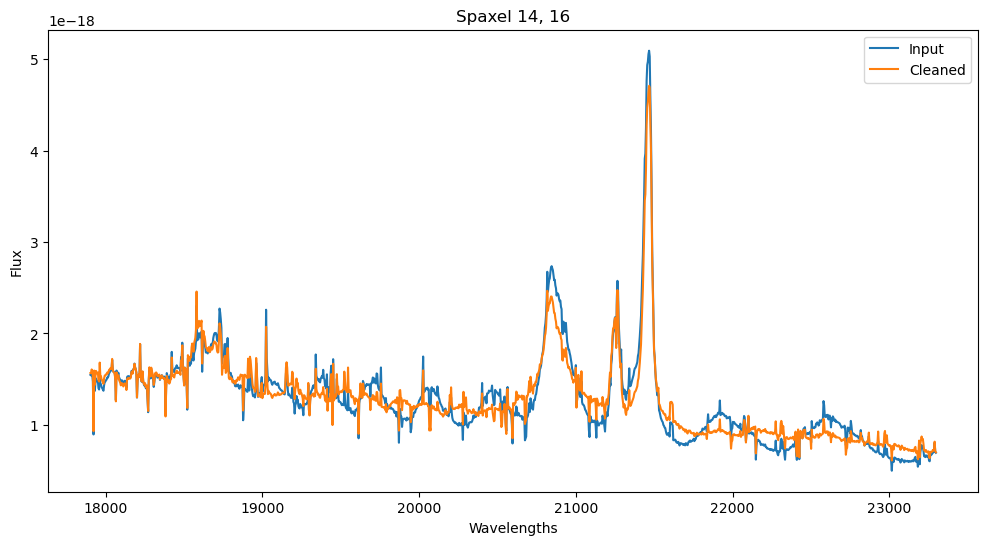

Wiggle detected!! Cleaning spaxel: 14, 17...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 15529.785817958607
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 15522.649560211554
n_amplitude: 5, n_offset: 2, n_frequency: 2, BIC: 15515.940776905833
n_amplitude: 4, n_offset: 2, n_frequency: 2, BIC: 15515.118503976737
n_amplitude: 4, n_offset: 1, n_frequency: 2, BIC: 15514.63783676021
n_amplitude: 3, n_offset: 1, n_frequency: 2, BIC: 15513.510192724953
Best n_amplitude:  3
Best n_offset:  1
Best n_frequency:  2


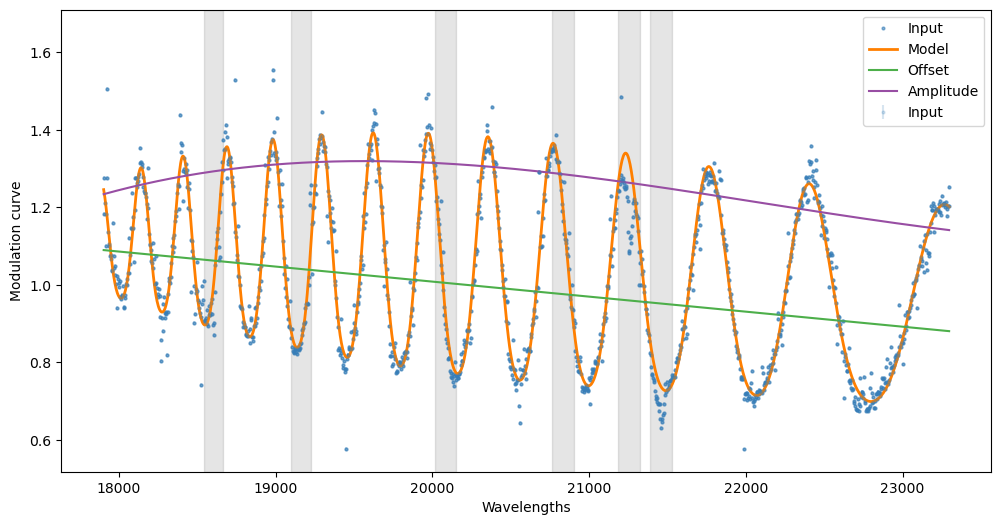

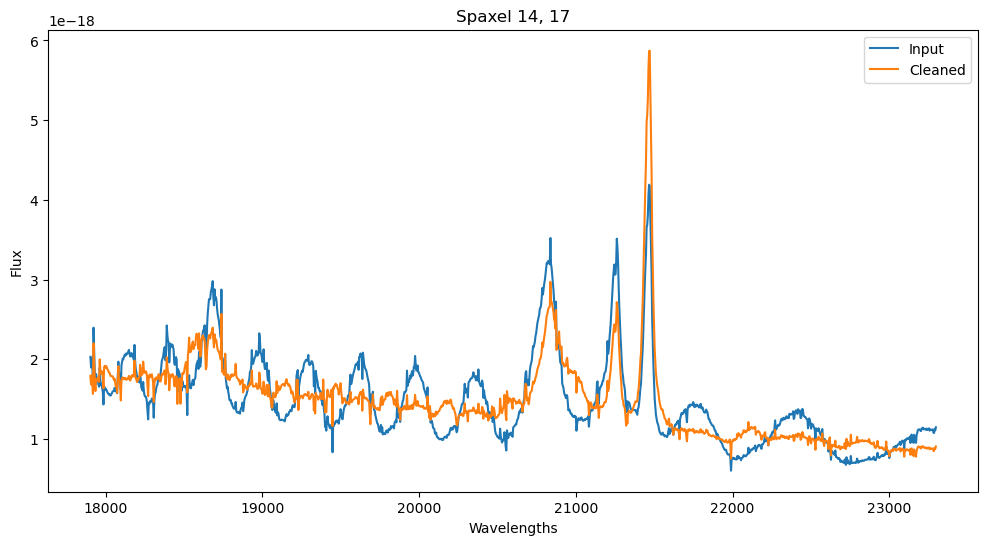

Wiggle detected!! Cleaning spaxel: 14, 18...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16804.023371478386
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 16796.81778190428
n_amplitude: 5, n_offset: 2, n_frequency: 2, BIC: 16790.45108387454
n_amplitude: 5, n_offset: 1, n_frequency: 2, BIC: 16783.478413810506
n_amplitude: 4, n_offset: 1, n_frequency: 2, BIC: 16777.41754481844
n_amplitude: 3, n_offset: 1, n_frequency: 2, BIC: 16775.256670526527
Best n_amplitude:  3
Best n_offset:  1
Best n_frequency:  2


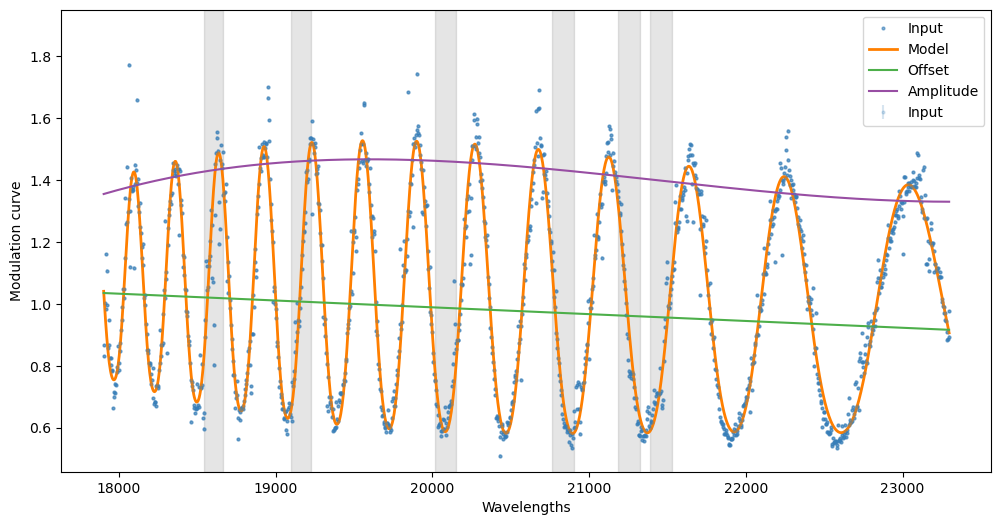

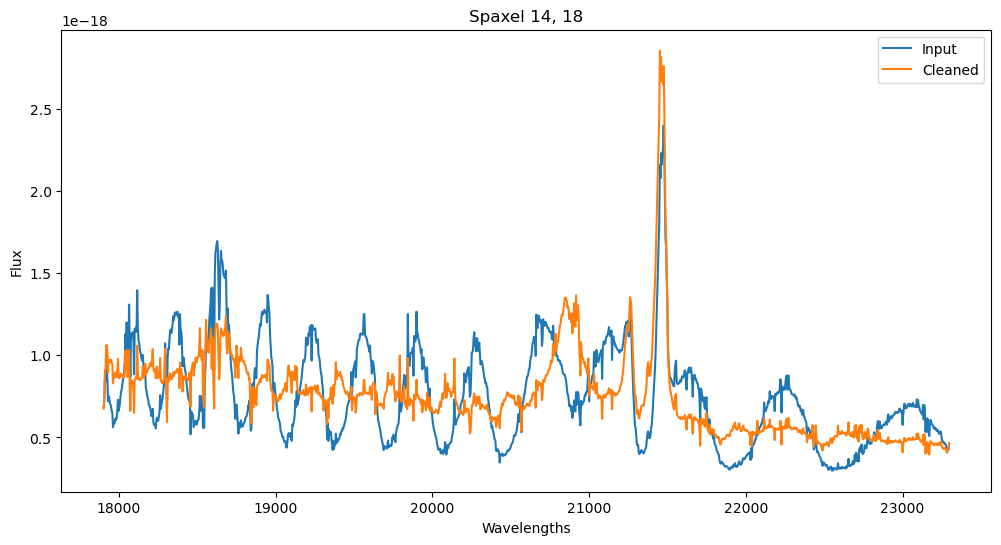

Wiggle detected!! Cleaning spaxel: 15, 14...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16552.025333797355
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 16547.222432045986
n_amplitude: 5, n_offset: 3, n_frequency: 1, BIC: 16541.58331148187
n_amplitude: 5, n_offset: 2, n_frequency: 2, BIC: 16540.298450519833
n_amplitude: 5, n_offset: 2, n_frequency: 1, BIC: 16535.63913266764
n_amplitude: 4, n_offset: 3, n_frequency: 1, BIC: 16534.39504933967
n_amplitude: 4, n_offset: 2, n_frequency: 2, BIC: 16533.10670796546
n_amplitude: 4, n_offset: 2, n_frequency: 1, BIC: 16528.480957872
n_amplitude: 3, n_offset: 2, n_frequency: 2, BIC: 16527.772438635737
n_amplitude: 3, n_offset: 2, n_frequency: 1, BIC: 16522.88974288149
Best n_amplitude:  3
Best n_offset:  2
Best n_frequency:  1


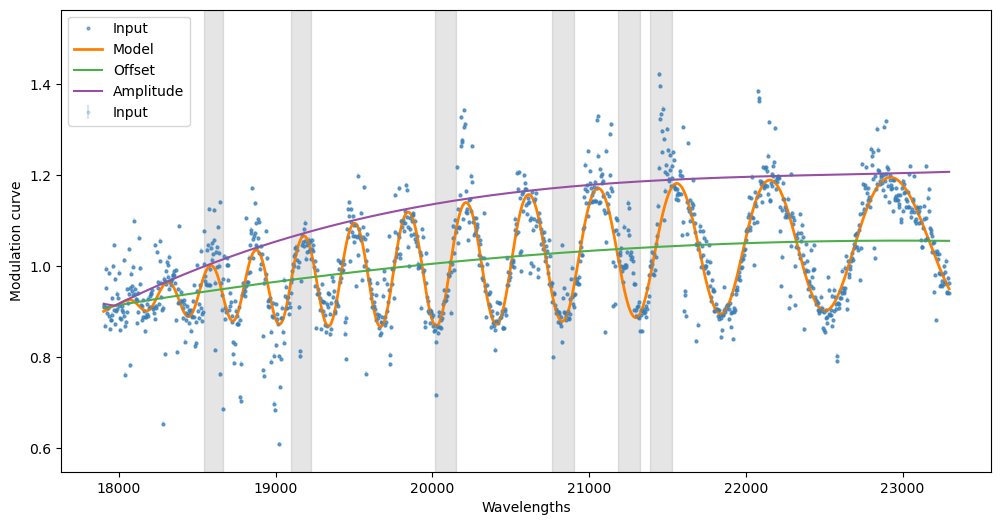

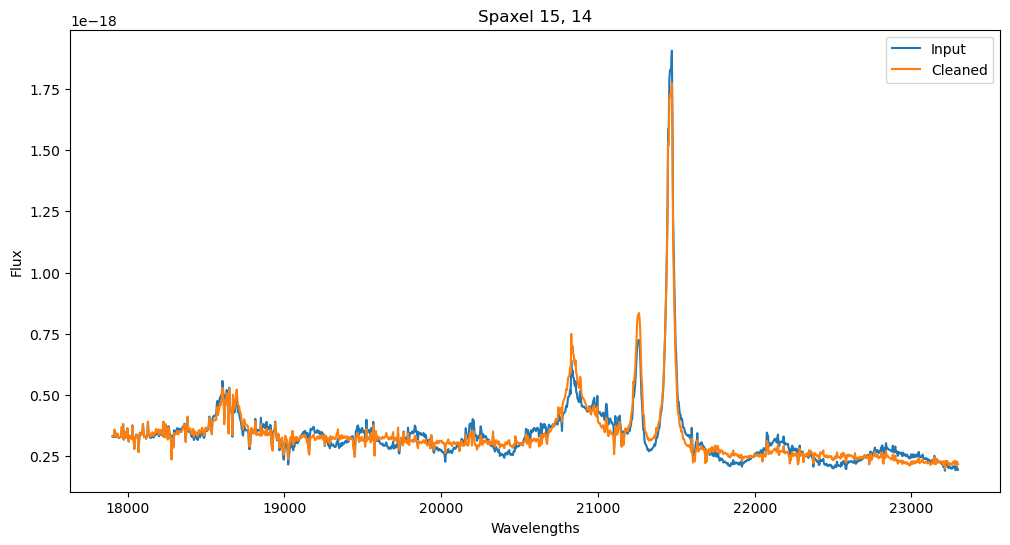

Wiggle detected!! Cleaning spaxel: 15, 15...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 17174.503095859767
n_amplitude: 5, n_offset: 3, n_frequency: 1, BIC: 16940.805125681625
n_amplitude: 2, n_offset: 3, n_frequency: 3, BIC: 16925.79854957424
n_amplitude: 2, n_offset: 2, n_frequency: 3, BIC: 16922.235264042898
n_amplitude: 2, n_offset: 1, n_frequency: 3, BIC: 16915.762043675906
Best n_amplitude:  2
Best n_offset:  1
Best n_frequency:  3


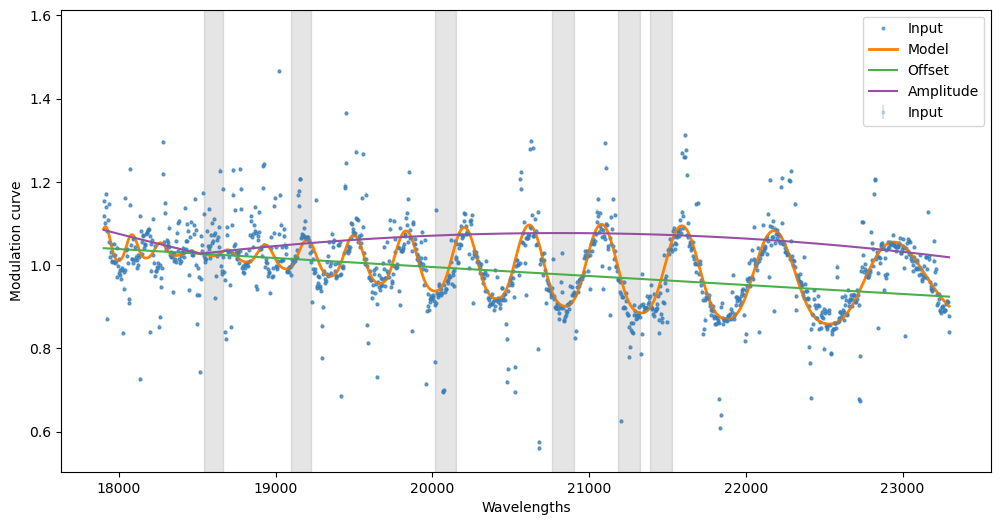

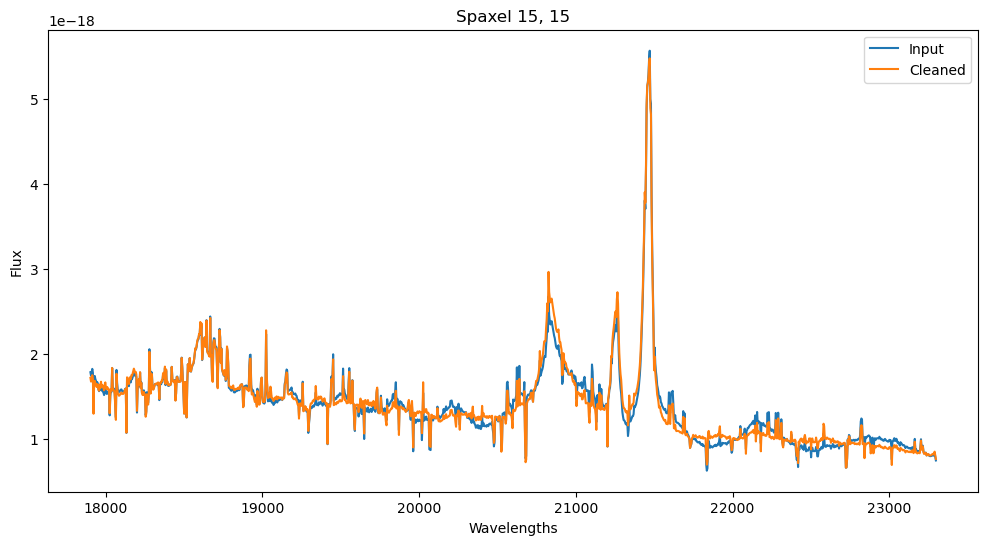

Wiggle detected!! Cleaning spaxel: 15, 16...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 14545.995089562262
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 14540.715290442067
n_amplitude: 5, n_offset: 2, n_frequency: 2, BIC: 14537.182188602015
n_amplitude: 4, n_offset: 2, n_frequency: 2, BIC: 14535.145729316648
n_amplitude: 3, n_offset: 2, n_frequency: 2, BIC: 14533.871891042707
Best n_amplitude:  3
Best n_offset:  2
Best n_frequency:  2


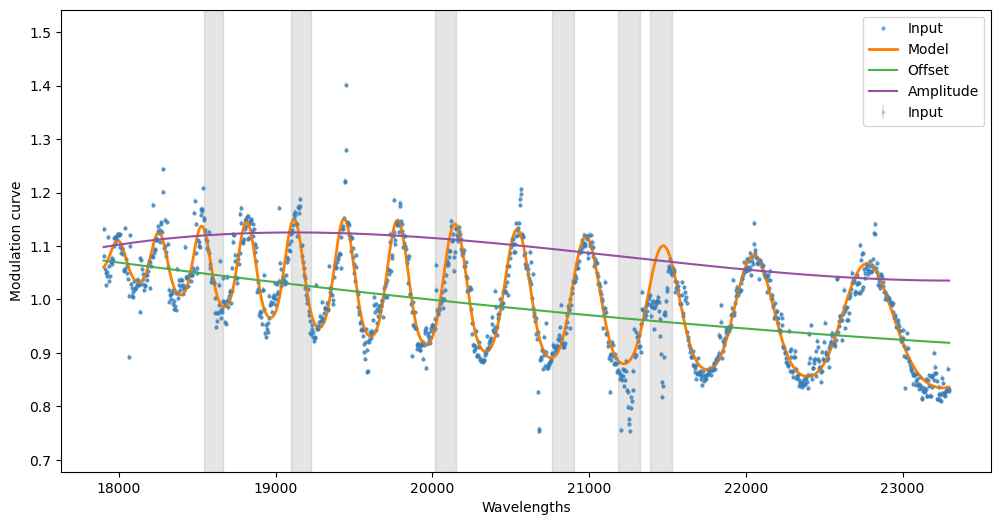

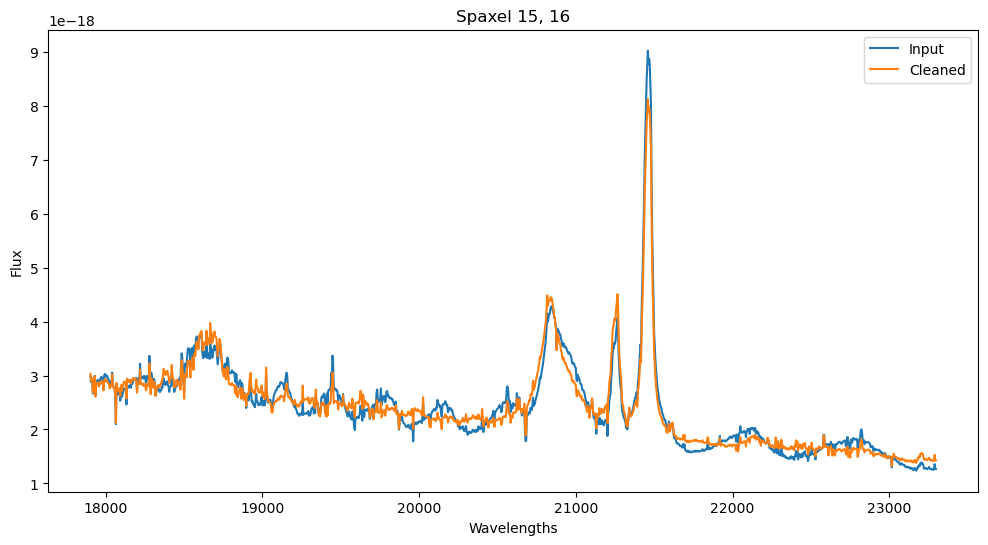

Wiggle detected!! Cleaning spaxel: 15, 17...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 14769.553111194722
n_amplitude: 5, n_offset: 2, n_frequency: 3, BIC: 14763.063355713773
n_amplitude: 5, n_offset: 1, n_frequency: 3, BIC: 14755.864504257102
n_amplitude: 4, n_offset: 1, n_frequency: 3, BIC: 14749.074432235033
Best n_amplitude:  4
Best n_offset:  1
Best n_frequency:  3


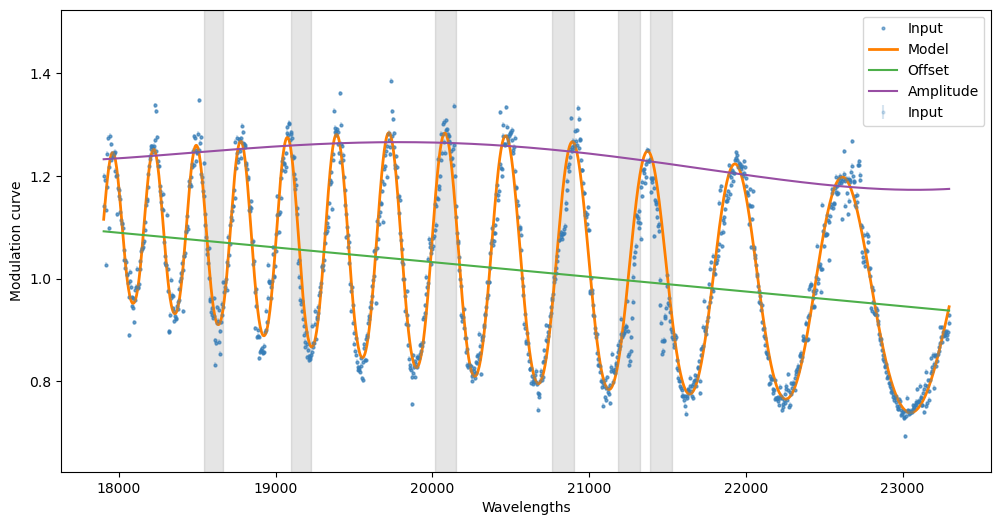

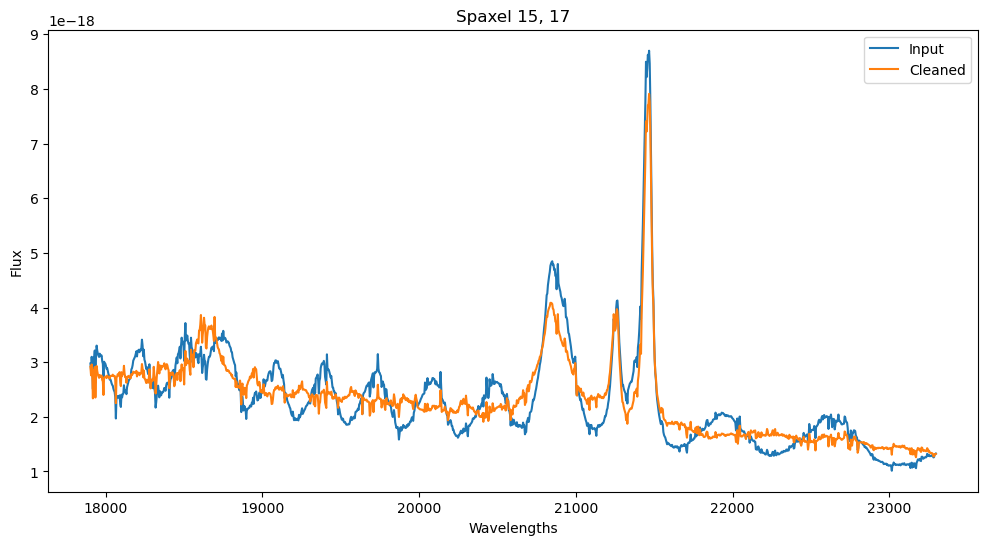

Wiggle detected!! Cleaning spaxel: 15, 18...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16362.486727385147
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 16357.252376077135
n_amplitude: 4, n_offset: 3, n_frequency: 3, BIC: 16356.681806133063
n_amplitude: 4, n_offset: 3, n_frequency: 2, BIC: 16351.427418079906
n_amplitude: 3, n_offset: 3, n_frequency: 3, BIC: 16351.09564493613
n_amplitude: 3, n_offset: 3, n_frequency: 2, BIC: 16346.284726750528
n_amplitude: 2, n_offset: 3, n_frequency: 2, BIC: 16342.678128051446
Best n_amplitude:  2
Best n_offset:  3
Best n_frequency:  2


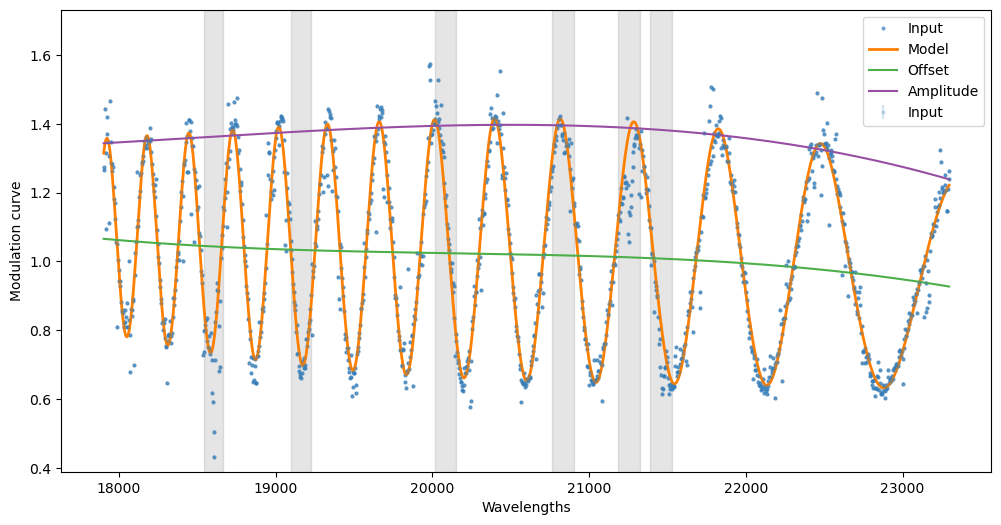

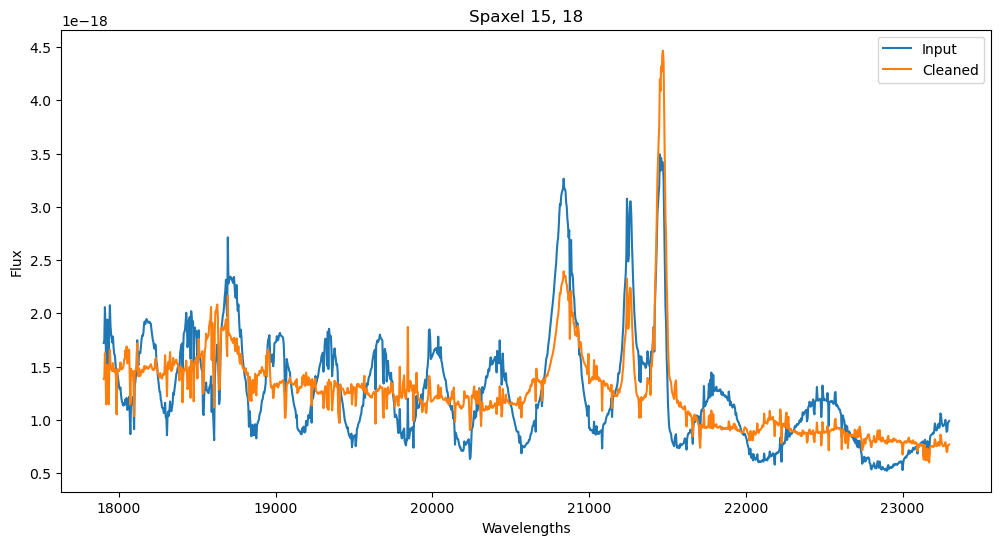

Wiggle detected!! Cleaning spaxel: 16, 14...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16892.722425049884
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 16886.332378420208
n_amplitude: 5, n_offset: 2, n_frequency: 3, BIC: 16885.81898962112
n_amplitude: 5, n_offset: 2, n_frequency: 2, BIC: 16878.892280576154
n_amplitude: 5, n_offset: 1, n_frequency: 2, BIC: 16874.815597188943
n_amplitude: 4, n_offset: 2, n_frequency: 2, BIC: 16872.029731393268
n_amplitude: 4, n_offset: 1, n_frequency: 2, BIC: 16868.51089985895
n_amplitude: 2, n_offset: 1, n_frequency: 2, BIC: 16866.122873980312
Best n_amplitude:  2
Best n_offset:  1
Best n_frequency:  2


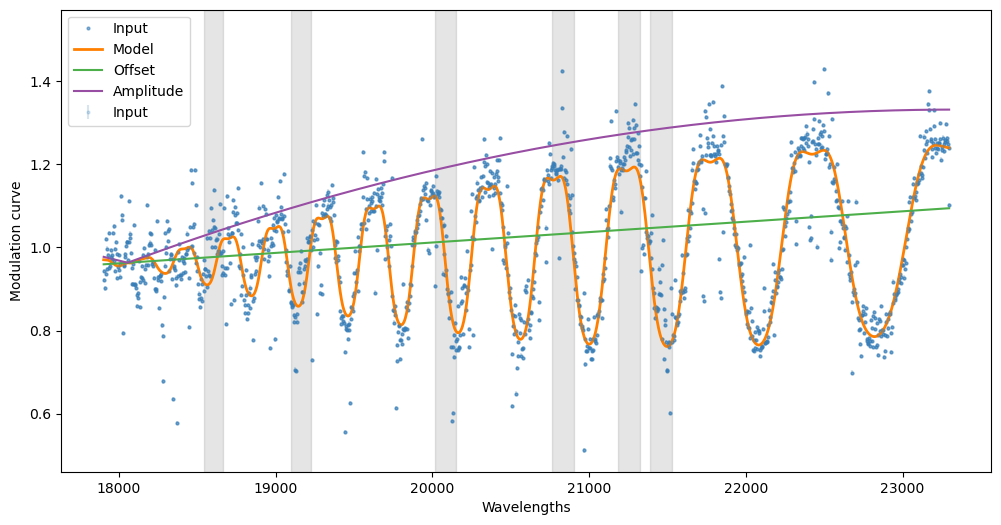

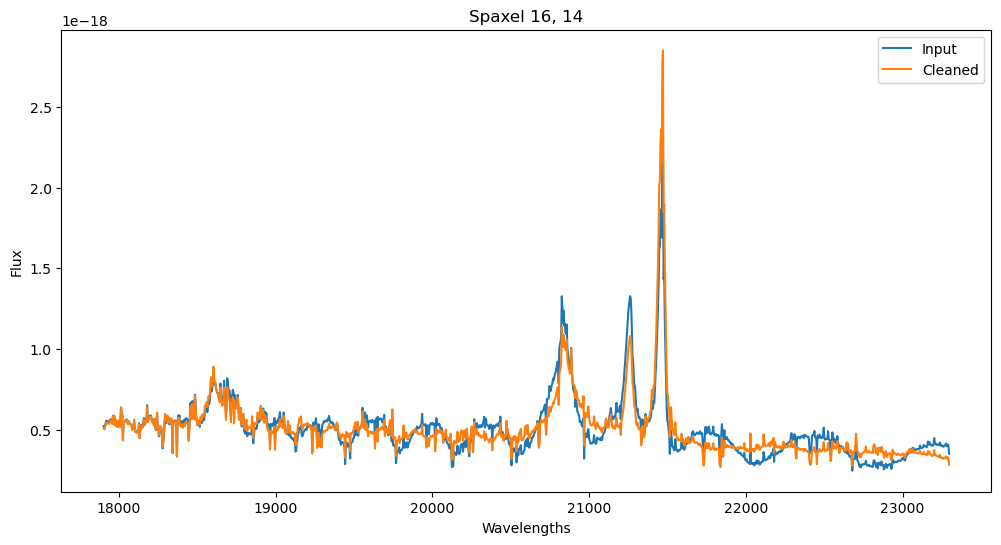

Wiggle detected!! Cleaning spaxel: 16, 15...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16330.276162114329
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 16323.1323297452
n_amplitude: 5, n_offset: 3, n_frequency: 1, BIC: 16316.602470171192
n_amplitude: 5, n_offset: 2, n_frequency: 1, BIC: 16315.793701328106
n_amplitude: 5, n_offset: 1, n_frequency: 2, BIC: 16315.728556578619
n_amplitude: 5, n_offset: 1, n_frequency: 1, BIC: 16308.823501370189
n_amplitude: 4, n_offset: 1, n_frequency: 1, BIC: 16302.62942302414
n_amplitude: 3, n_offset: 3, n_frequency: 1, BIC: 16302.456116744457
n_amplitude: 3, n_offset: 1, n_frequency: 2, BIC: 16302.182455370179
n_amplitude: 3, n_offset: 1, n_frequency: 1, BIC: 16295.469941232212
n_amplitude: 2, n_offset: 3, n_frequency: 1, BIC: 16295.254135541107
n_amplitude: 2, n_offset: 1, n_frequency: 1, BIC: 16289.013423141863
Best n_amplitude:  2
Best n_offset:  1
Best n_frequency:  1


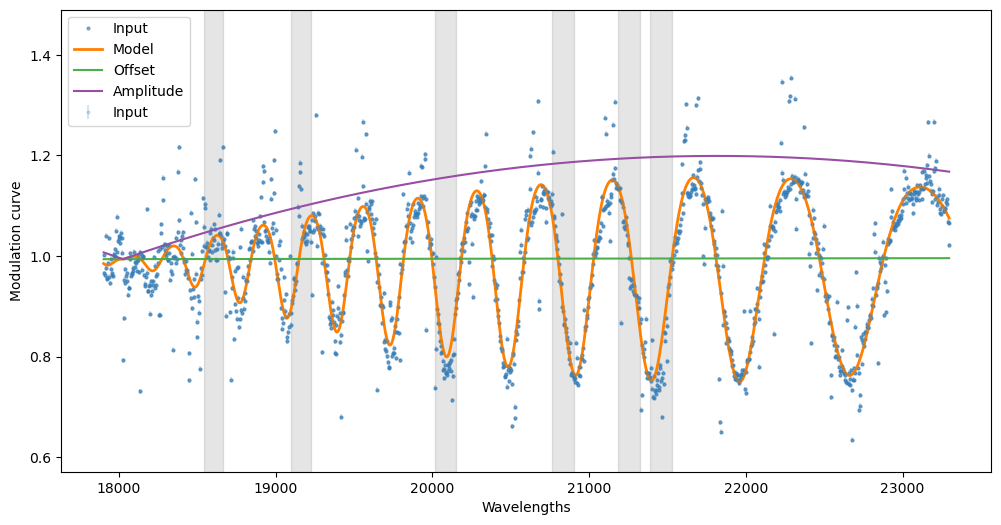

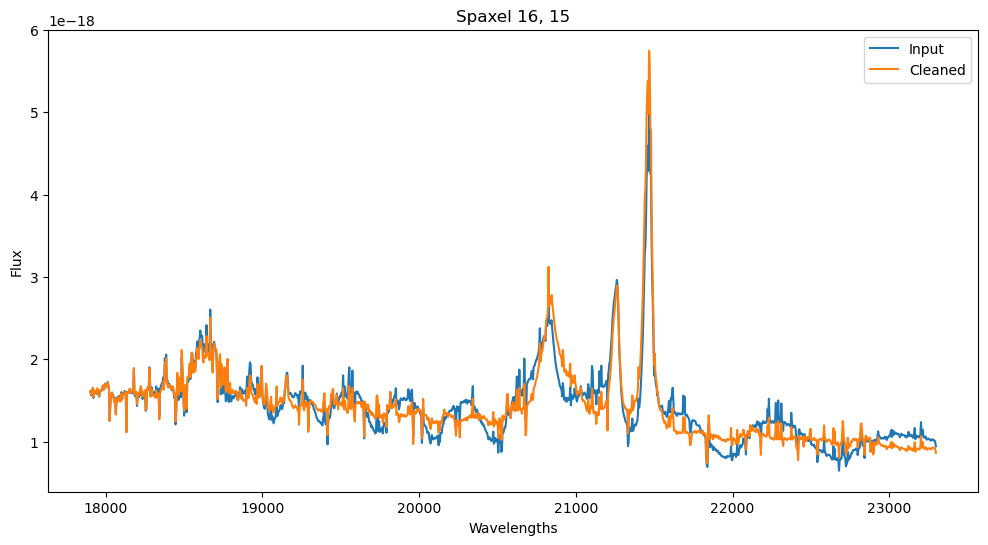

Wiggle detected!! Cleaning spaxel: 16, 16...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 13548.362598633916
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 13546.392241516687
n_amplitude: 5, n_offset: 2, n_frequency: 2, BIC: 13542.31910289796
n_amplitude: 4, n_offset: 3, n_frequency: 3, BIC: 13542.247719014957
n_amplitude: 4, n_offset: 3, n_frequency: 2, BIC: 13541.05897384518
n_amplitude: 4, n_offset: 2, n_frequency: 3, BIC: 13540.825535185199
n_amplitude: 4, n_offset: 2, n_frequency: 2, BIC: 13536.38431088841
n_amplitude: 3, n_offset: 2, n_frequency: 2, BIC: 13534.966193747945
Best n_amplitude:  3
Best n_offset:  2
Best n_frequency:  2


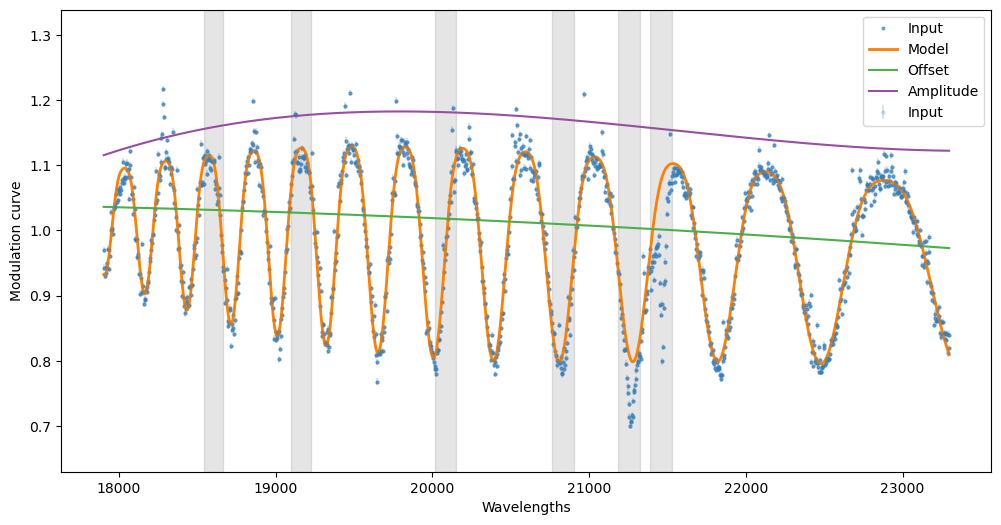

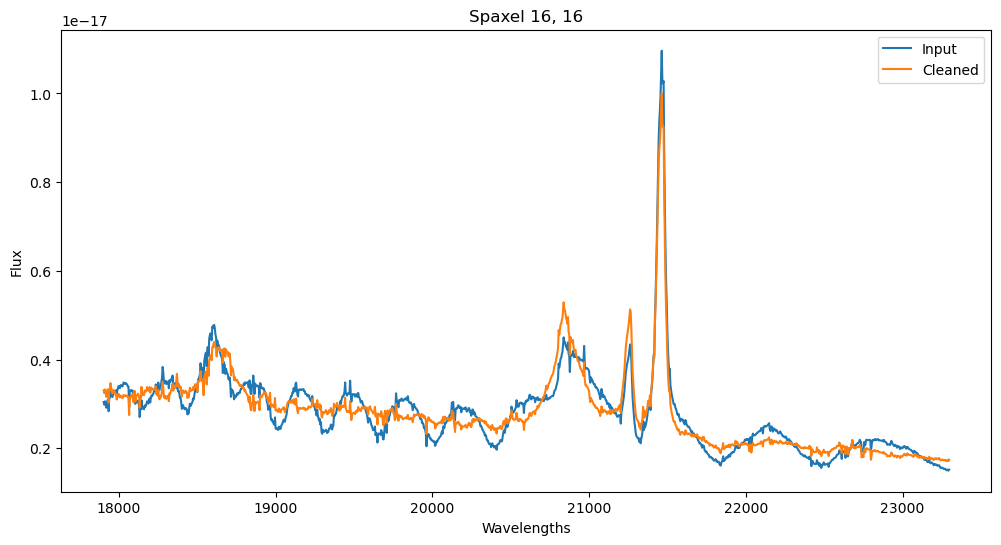

Wiggle detected!! Cleaning spaxel: 16, 17...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 15665.149520319741
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 15658.587314926102
n_amplitude: 5, n_offset: 3, n_frequency: 1, BIC: 15654.818935223506
n_amplitude: 5, n_offset: 2, n_frequency: 2, BIC: 15651.723039859802
n_amplitude: 5, n_offset: 2, n_frequency: 1, BIC: 15648.6582631736
n_amplitude: 4, n_offset: 3, n_frequency: 1, BIC: 15647.61185345154
n_amplitude: 4, n_offset: 2, n_frequency: 2, BIC: 15644.861559164612
n_amplitude: 4, n_offset: 2, n_frequency: 1, BIC: 15641.5207361691
n_amplitude: 3, n_offset: 2, n_frequency: 2, BIC: 15640.508601193282
n_amplitude: 3, n_offset: 2, n_frequency: 1, BIC: 15637.164898753847
n_amplitude: 2, n_offset: 2, n_frequency: 1, BIC: 15634.968149199622
Best n_amplitude:  2
Best n_offset:  2
Best n_frequency:  1


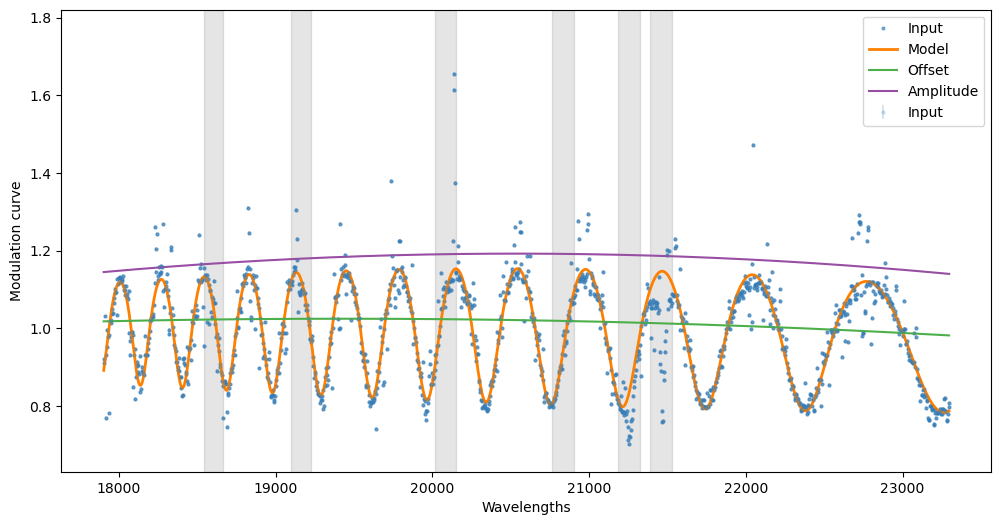

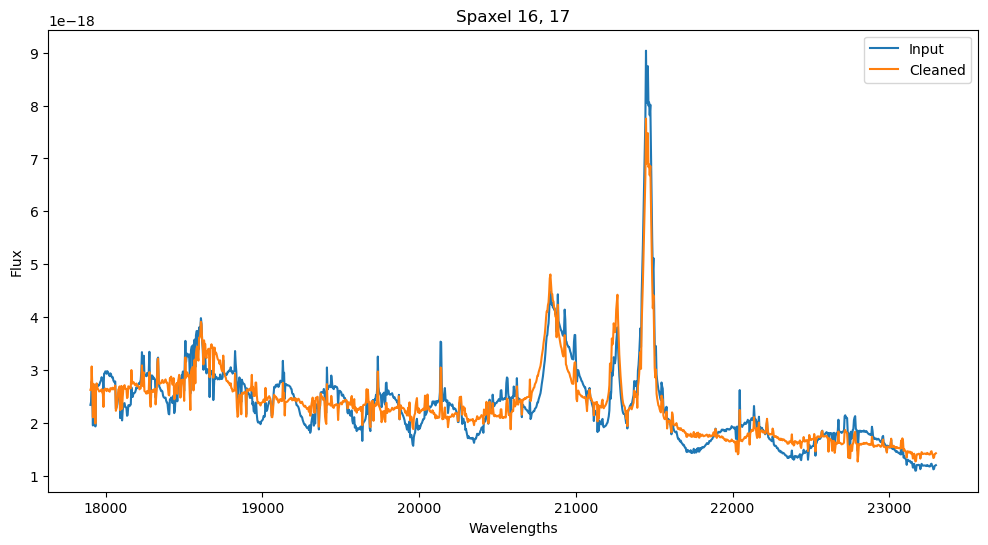

Wiggle detected!! Cleaning spaxel: 16, 18...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16227.594803968828
n_amplitude: 5, n_offset: 3, n_frequency: 1, BIC: 16218.738945668882
n_amplitude: 5, n_offset: 2, n_frequency: 1, BIC: 16213.89890430711
n_amplitude: 5, n_offset: 1, n_frequency: 1, BIC: 16209.453982698426
n_amplitude: 4, n_offset: 1, n_frequency: 2, BIC: 16207.270119022114
n_amplitude: 4, n_offset: 1, n_frequency: 1, BIC: 16204.45325672821
n_amplitude: 2, n_offset: 1, n_frequency: 1, BIC: 16202.854212729077
Best n_amplitude:  2
Best n_offset:  1
Best n_frequency:  1


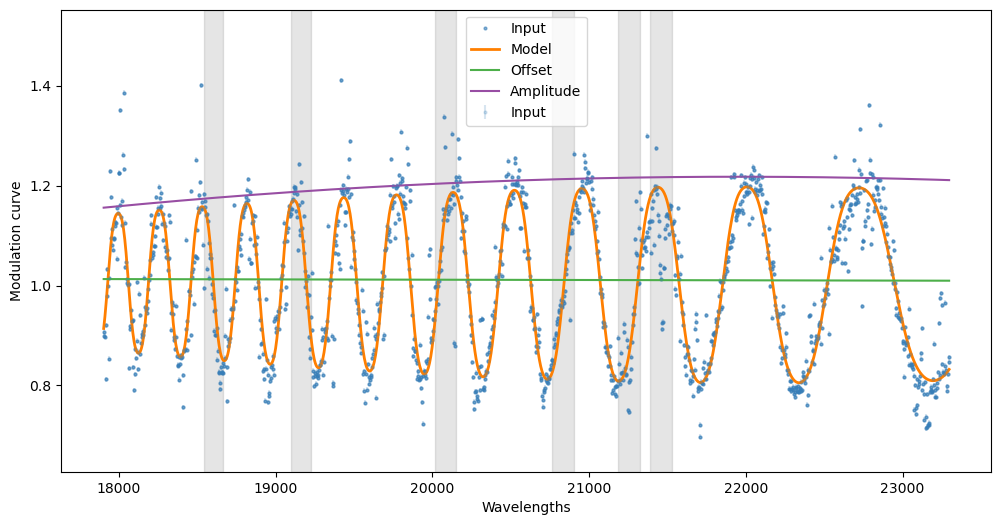

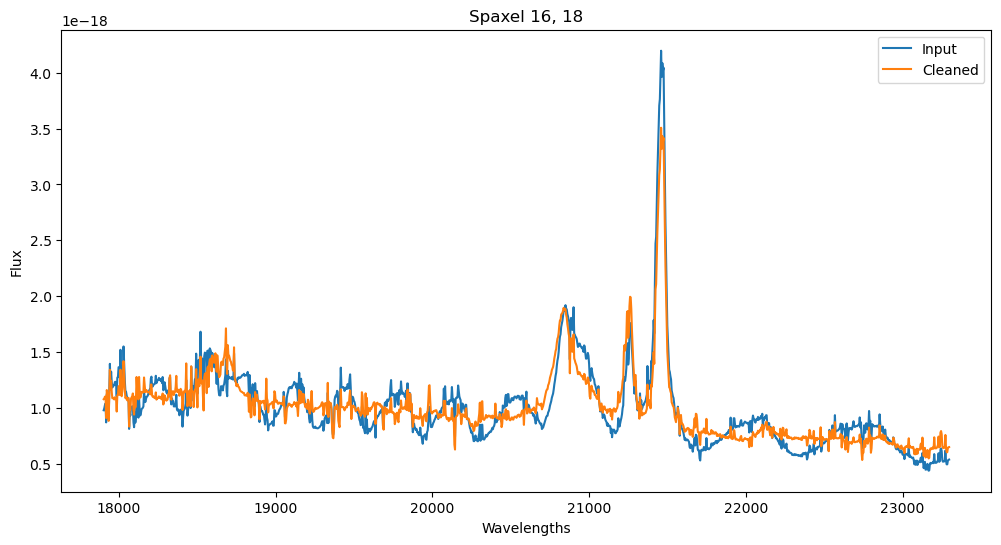

Wiggle detected!! Cleaning spaxel: 17, 14...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 17778.493902144175
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 17769.12340034111
n_amplitude: 5, n_offset: 3, n_frequency: 1, BIC: 17763.668859512334
n_amplitude: 5, n_offset: 2, n_frequency: 1, BIC: 17757.433555177195
n_amplitude: 5, n_offset: 1, n_frequency: 1, BIC: 17750.414021282366
n_amplitude: 4, n_offset: 1, n_frequency: 1, BIC: 17750.288900822547
n_amplitude: 3, n_offset: 2, n_frequency: 1, BIC: 17749.12169120423
n_amplitude: 3, n_offset: 1, n_frequency: 2, BIC: 17748.3336243583
n_amplitude: 3, n_offset: 1, n_frequency: 1, BIC: 17743.110830945527
n_amplitude: 2, n_offset: 2, n_frequency: 1, BIC: 17742.924557182265
n_amplitude: 2, n_offset: 1, n_frequency: 3, BIC: 17742.278648008232
n_amplitude: 2, n_offset: 1, n_frequency: 2, BIC: 17741.80874223161
n_amplitude: 2, n_offset: 1, n_frequency: 1, BIC: 17737.41677382142
Best n_amplitude:  2
Best n_offset:  1
Best n_frequency:  1


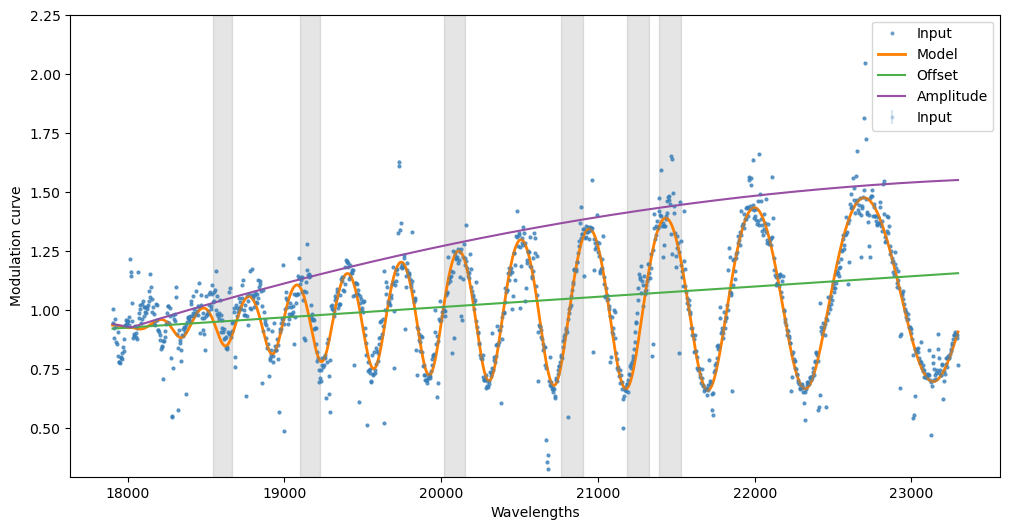

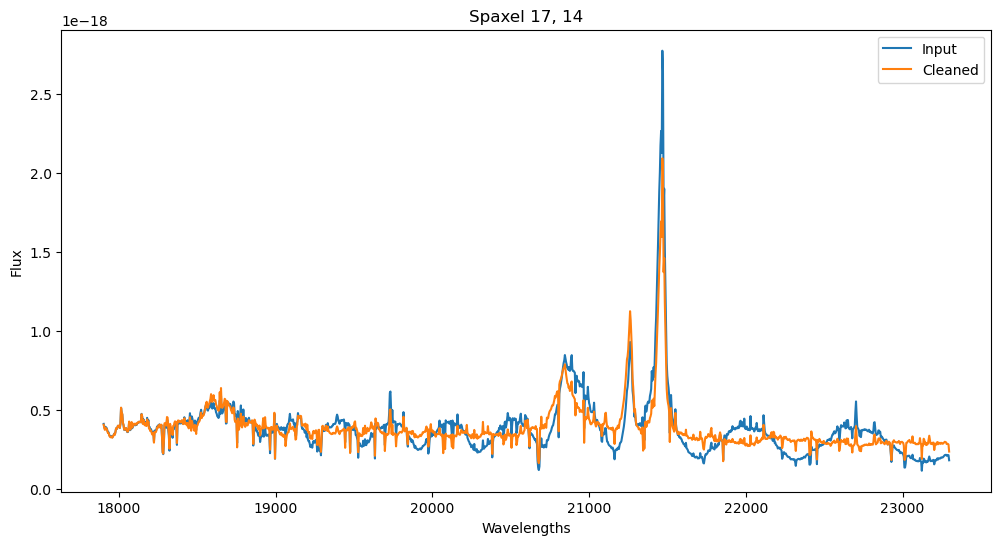

Wiggle detected!! Cleaning spaxel: 17, 15...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16361.435979194546
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 16354.714773652615
n_amplitude: 5, n_offset: 2, n_frequency: 2, BIC: 16354.557795074703
n_amplitude: 5, n_offset: 1, n_frequency: 2, BIC: 16353.320859347294
n_amplitude: 4, n_offset: 3, n_frequency: 2, BIC: 16348.51255907306
n_amplitude: 4, n_offset: 1, n_frequency: 2, BIC: 16347.80232006364
n_amplitude: 3, n_offset: 3, n_frequency: 2, BIC: 16341.90956850886
n_amplitude: 3, n_offset: 1, n_frequency: 2, BIC: 16341.729404034764
Best n_amplitude:  3
Best n_offset:  1
Best n_frequency:  2


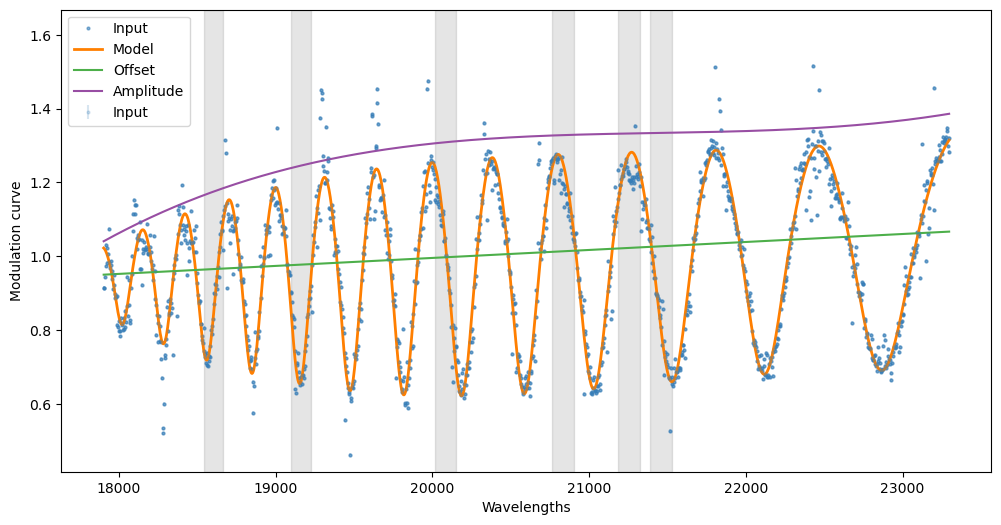

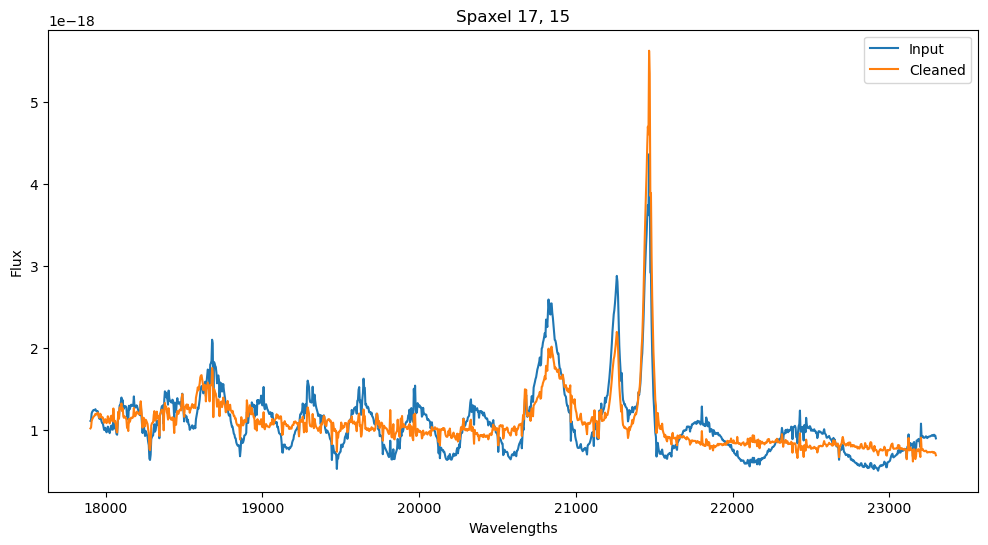

Wiggle detected!! Cleaning spaxel: 17, 16...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 15670.930070342398
n_amplitude: 5, n_offset: 2, n_frequency: 3, BIC: 15663.82109887176
n_amplitude: 4, n_offset: 2, n_frequency: 3, BIC: 15657.676281386524
n_amplitude: 3, n_offset: 2, n_frequency: 3, BIC: 15651.403319090401
Best n_amplitude:  3
Best n_offset:  2
Best n_frequency:  3


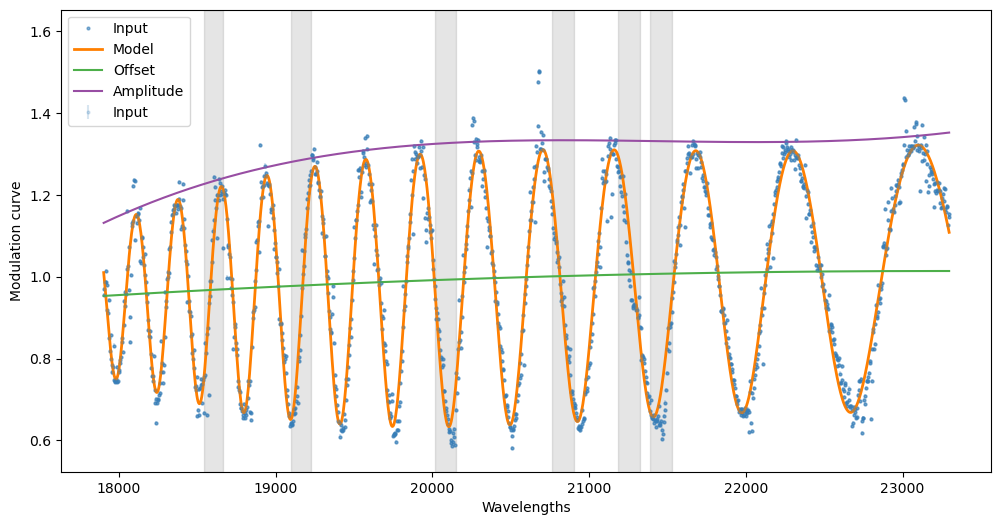

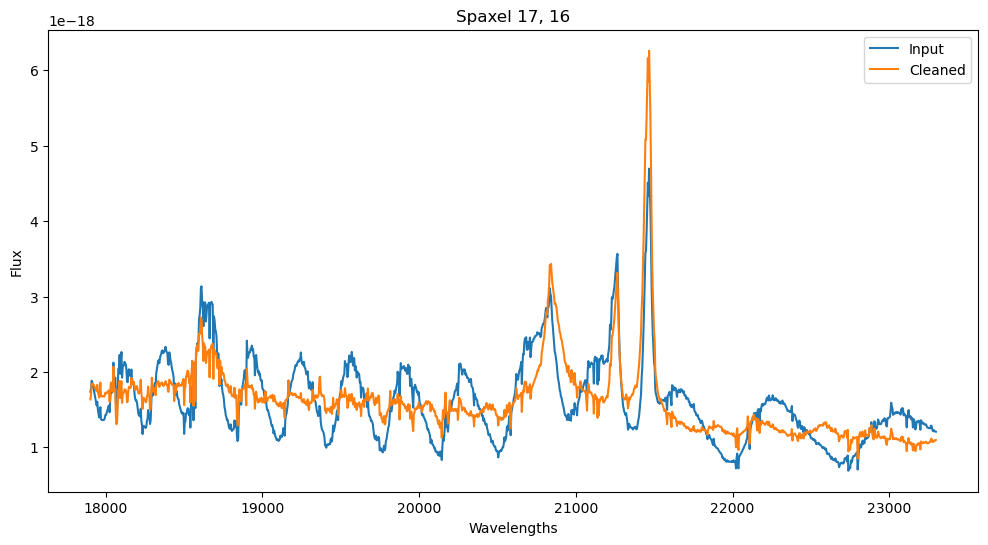

Wiggle detected!! Cleaning spaxel: 17, 17...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16028.199733256832
n_amplitude: 5, n_offset: 2, n_frequency: 3, BIC: 16028.070266293635
n_amplitude: 5, n_offset: 1, n_frequency: 3, BIC: 16025.263969078618
n_amplitude: 4, n_offset: 3, n_frequency: 3, BIC: 16022.0651117642
n_amplitude: 4, n_offset: 1, n_frequency: 3, BIC: 16020.360843311513
n_amplitude: 3, n_offset: 3, n_frequency: 3, BIC: 16019.48036635641
n_amplitude: 3, n_offset: 2, n_frequency: 3, BIC: 16017.738457815509
n_amplitude: 3, n_offset: 1, n_frequency: 3, BIC: 16015.7226117347
Best n_amplitude:  3
Best n_offset:  1
Best n_frequency:  3


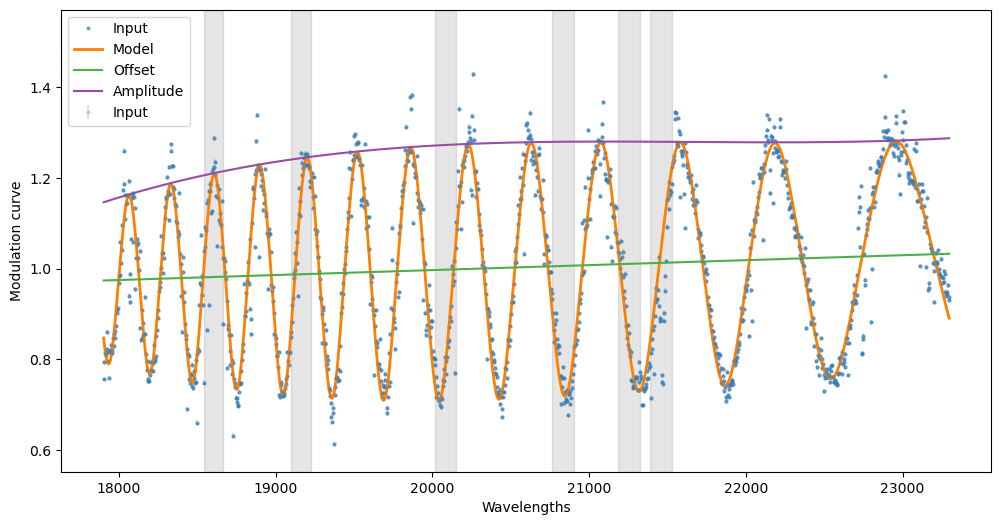

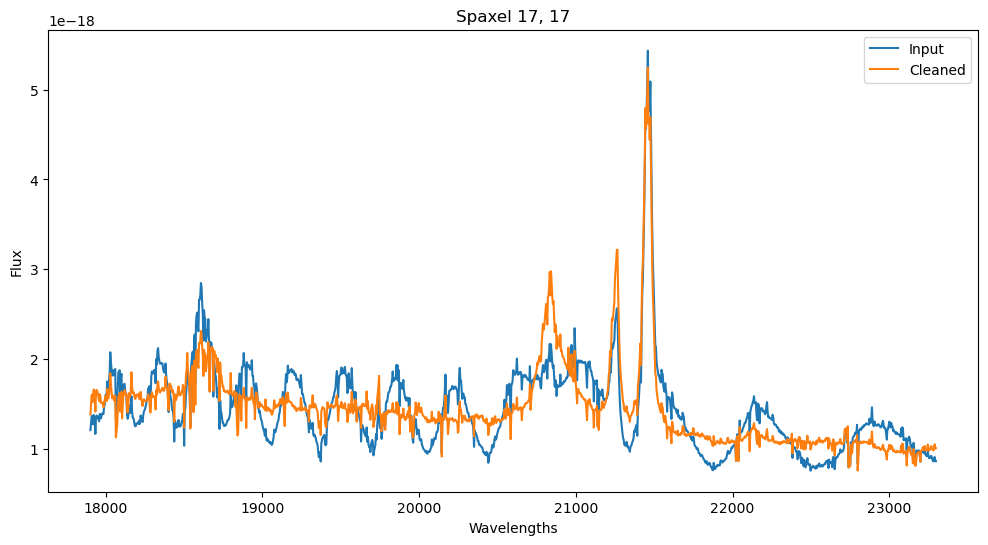

Wiggle detected!! Cleaning spaxel: 17, 18...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 17211.501234919368
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 17204.5326274387
n_amplitude: 5, n_offset: 3, n_frequency: 1, BIC: 17197.576448614003
n_amplitude: 5, n_offset: 2, n_frequency: 1, BIC: 17190.65312163268
n_amplitude: 4, n_offset: 2, n_frequency: 1, BIC: 17186.11055866699
n_amplitude: 3, n_offset: 3, n_frequency: 1, BIC: 17185.949693160874
n_amplitude: 3, n_offset: 2, n_frequency: 1, BIC: 17179.02479633398
n_amplitude: 2, n_offset: 2, n_frequency: 1, BIC: 17173.483934669694
n_amplitude: 1, n_offset: 2, n_frequency: 1, BIC: 17169.15631074134
Best n_amplitude:  1
Best n_offset:  2
Best n_frequency:  1


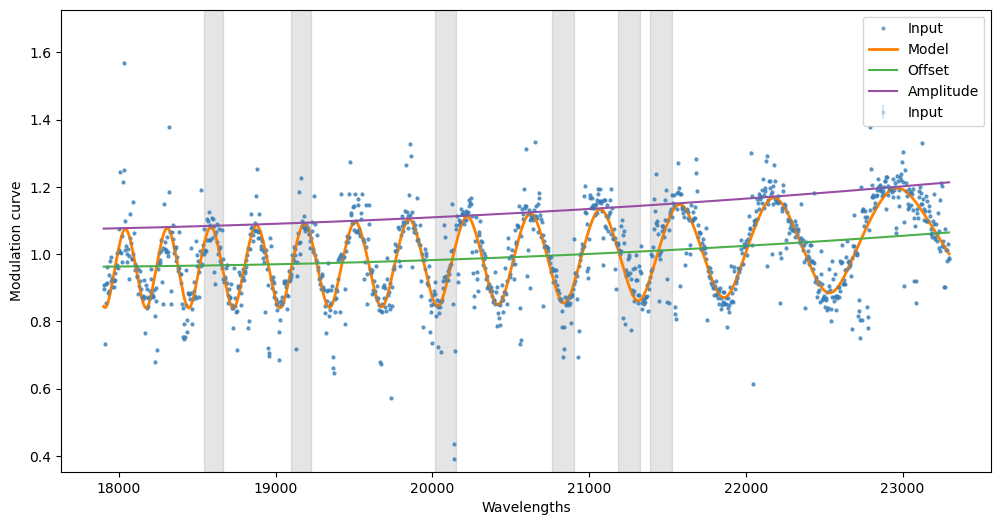

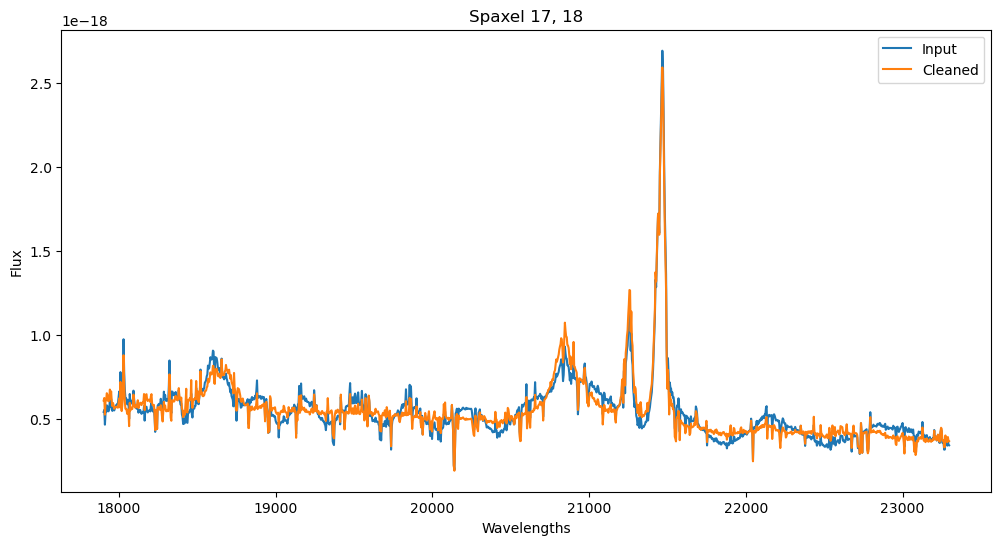

Wiggle detected!! Cleaning spaxel: 18, 14...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16935.57962697191
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 16928.83817704441
n_amplitude: 5, n_offset: 2, n_frequency: 3, BIC: 16928.491227301125
n_amplitude: 5, n_offset: 2, n_frequency: 2, BIC: 16922.009959253344
n_amplitude: 5, n_offset: 1, n_frequency: 2, BIC: 16921.773313380592
n_amplitude: 5, n_offset: 1, n_frequency: 1, BIC: 16921.3024517575
n_amplitude: 4, n_offset: 2, n_frequency: 2, BIC: 16914.81617661762
n_amplitude: 4, n_offset: 1, n_frequency: 2, BIC: 16914.57148139387
n_amplitude: 4, n_offset: 1, n_frequency: 1, BIC: 16914.130954703458
n_amplitude: 3, n_offset: 2, n_frequency: 2, BIC: 16910.57881566834
n_amplitude: 3, n_offset: 1, n_frequency: 2, BIC: 16909.18756200713
n_amplitude: 3, n_offset: 1, n_frequency: 1, BIC: 16908.27674786327
n_amplitude: 2, n_offset: 2, n_frequency: 2, BIC: 16907.88078579838
Best n_amplitude:  2
Best n_offset:  2
Best n_frequency:  2


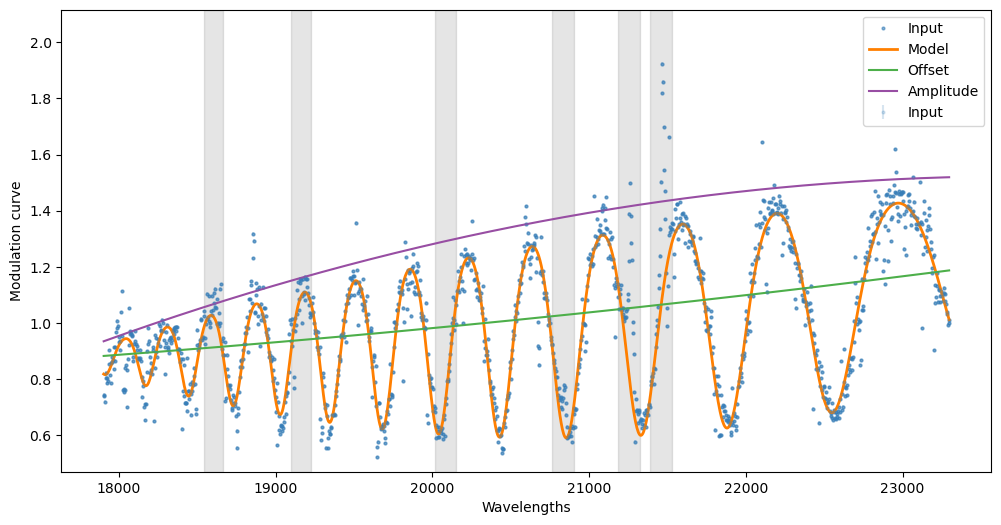

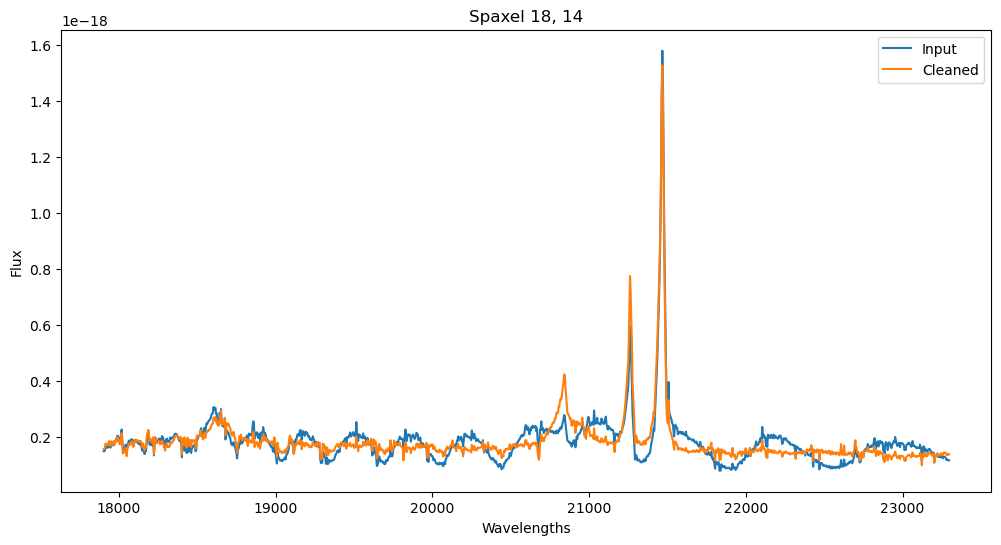

Wiggle detected!! Cleaning spaxel: 18, 15...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 17023.043564787517
n_amplitude: 5, n_offset: 2, n_frequency: 3, BIC: 17016.743082994584
n_amplitude: 5, n_offset: 1, n_frequency: 3, BIC: 17011.494198123793
n_amplitude: 5, n_offset: 1, n_frequency: 1, BIC: 17010.3894464101
n_amplitude: 4, n_offset: 2, n_frequency: 3, BIC: 17009.75711159645
n_amplitude: 4, n_offset: 1, n_frequency: 3, BIC: 17005.227135964178
n_amplitude: 4, n_offset: 1, n_frequency: 1, BIC: 17003.907881325034
Best n_amplitude:  4
Best n_offset:  1
Best n_frequency:  1


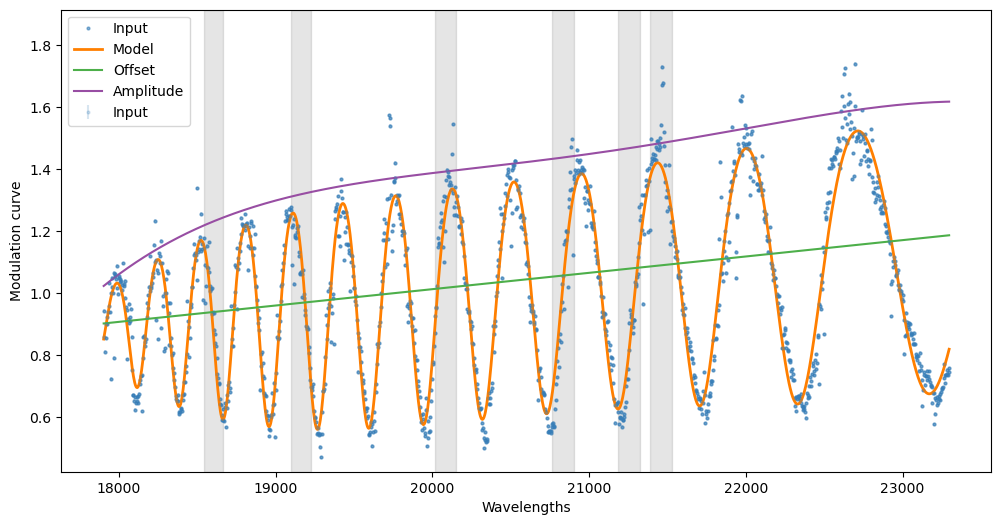

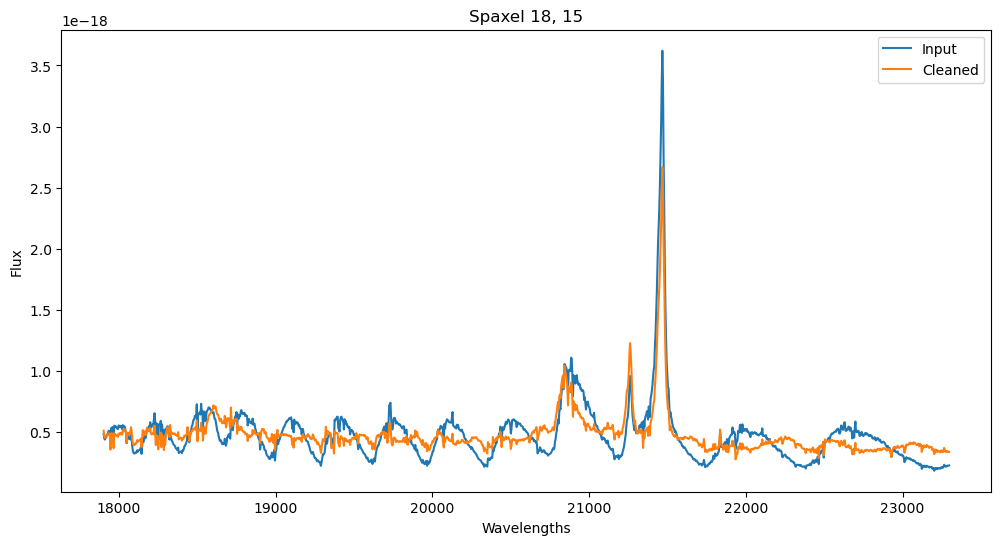

Wiggle detected!! Cleaning spaxel: 18, 16...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16685.485024626774
n_amplitude: 5, n_offset: 2, n_frequency: 3, BIC: 16684.334788875873
n_amplitude: 5, n_offset: 2, n_frequency: 2, BIC: 16681.640307924223
n_amplitude: 5, n_offset: 1, n_frequency: 3, BIC: 16678.340934761294
n_amplitude: 5, n_offset: 1, n_frequency: 2, BIC: 16674.862216743037
Best n_amplitude:  5
Best n_offset:  1
Best n_frequency:  2


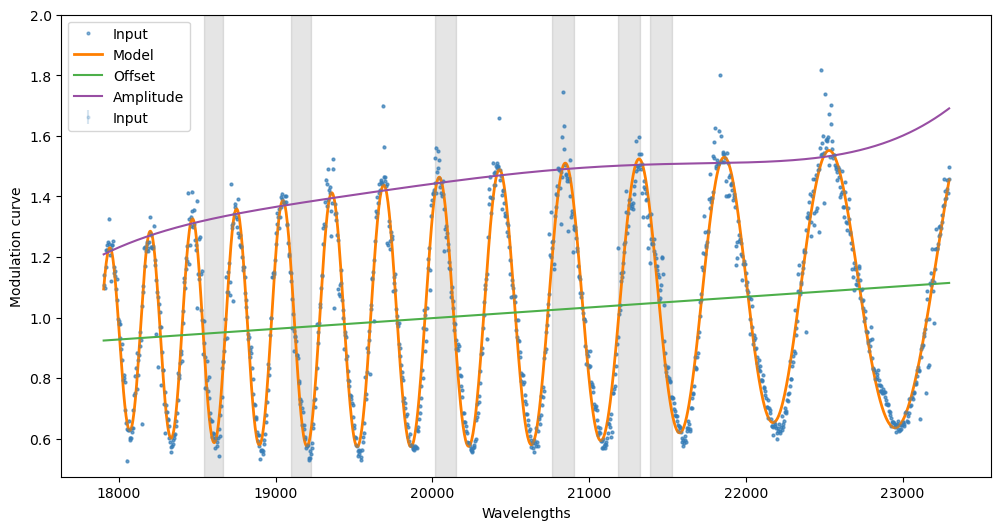

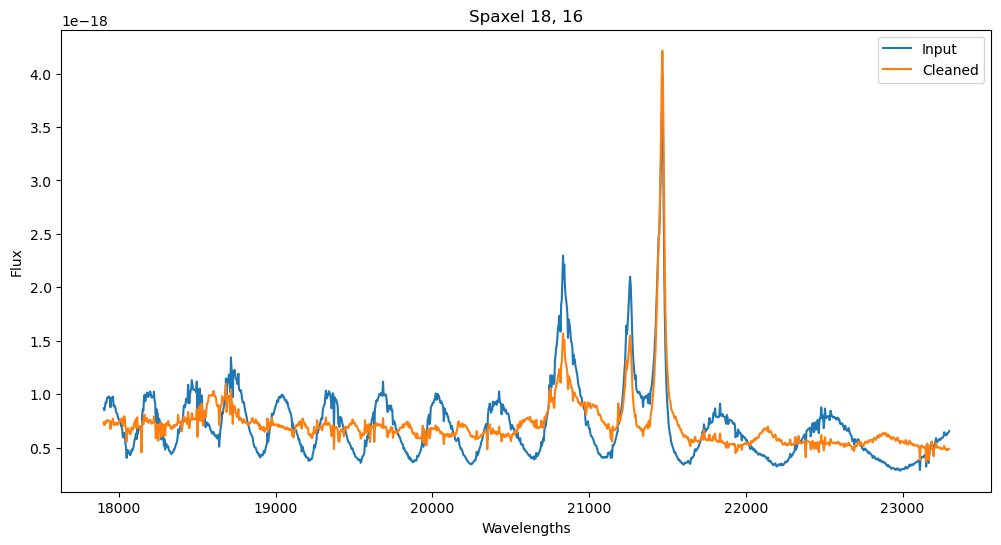

Wiggle detected!! Cleaning spaxel: 18, 17...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16694.05726835689
n_amplitude: 5, n_offset: 2, n_frequency: 3, BIC: 16690.463679305798
n_amplitude: 5, n_offset: 1, n_frequency: 3, BIC: 16683.351482162638
n_amplitude: 4, n_offset: 2, n_frequency: 3, BIC: 16683.286680910347
n_amplitude: 4, n_offset: 1, n_frequency: 3, BIC: 16676.149376243167
Best n_amplitude:  4
Best n_offset:  1
Best n_frequency:  3


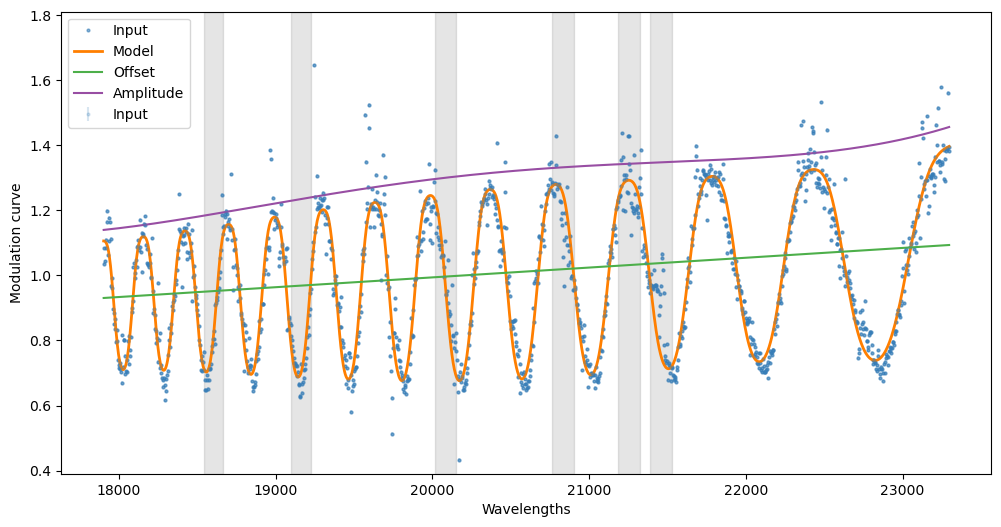

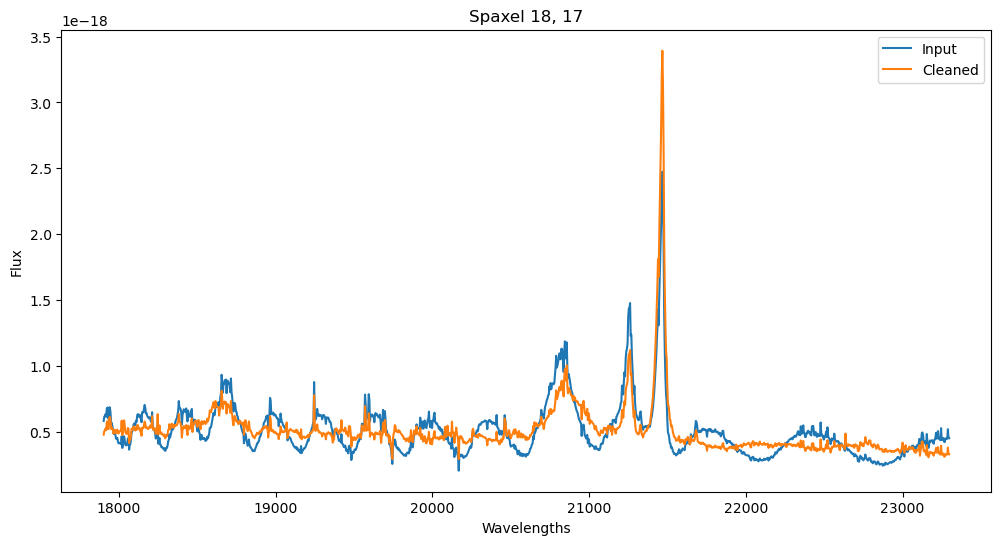

Wiggle detected!! Cleaning spaxel: 18, 18...
Computing BIC for choices of n_amplitude...


  0%|          | 0/5 [00:00<?, ?it/s]

n_amplitude: 5, n_offset: 3, n_frequency: 3, BIC: 16654.189572916483
n_amplitude: 5, n_offset: 3, n_frequency: 2, BIC: 16646.998094871575
n_amplitude: 4, n_offset: 3, n_frequency: 2, BIC: 16641.630939260238
n_amplitude: 1, n_offset: 3, n_frequency: 2, BIC: 16640.748367291944
n_amplitude: 1, n_offset: 2, n_frequency: 2, BIC: 16636.859311698543
Best n_amplitude:  1
Best n_offset:  2
Best n_frequency:  2


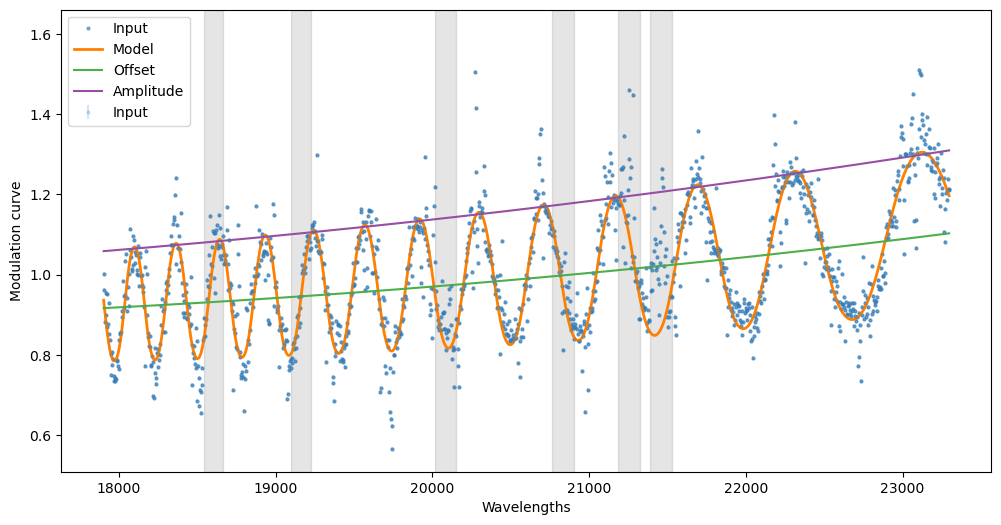

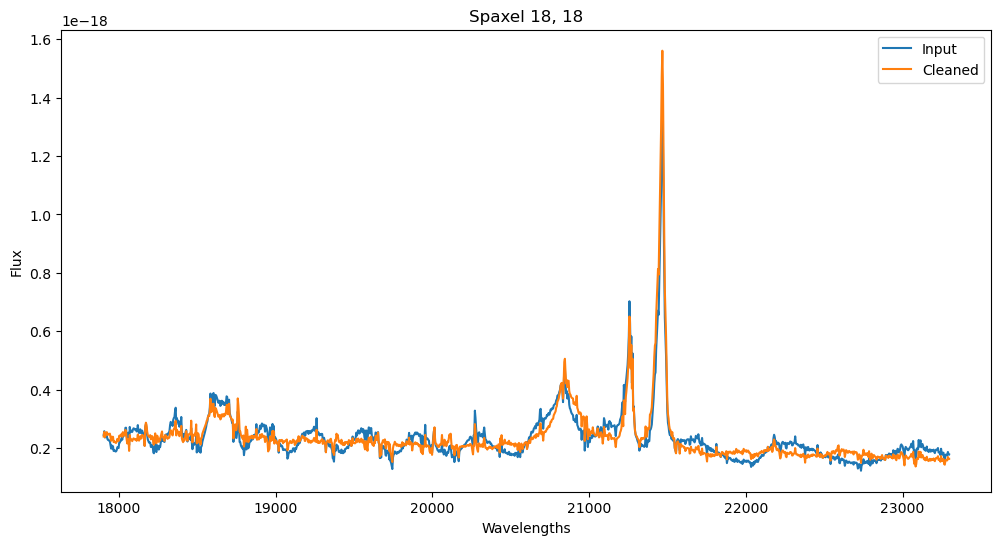

Cleaning done!


In [ ]:
warnings.filterwarnings("ignore")

cleaned_datacube, cleaned_noisecube = wcleaner.clean_cube(
    sigma_threshold=3,  # setting 3-sigma threshold for wiggle to be detected at a spaxel before cleaning
    n_amplitude=5,
    n_offset=3,
    n_frequency=3,
    min_n_amplitude=1,
    min_n_offset=1,
    min_n_frequency=1,
    proximity_threshold=100,
    aperture_size=aperture_size,
    min_x=14,
    max_x=19,
    min_y=14,
    max_y=19,
    conserve_flux=True,  # to make correction to conserve flux within each spaxel
    plot=True,
)

## Save the cleaned cube if everything looks fine!